# HR-аналитика

HR-аналитикам компании «Работа с заботой» поступили данные от заказчика. В пяти таблицах собрана информация, на основании которой нам необходимо построить две модели машинного обучения. Первая модель должна предсказывать уровень удовлетворенности сотрудником его работой, вторая модель должна предсказывать то, что сотрудник уволится из компании.

В таблицах `test_features.csv`, `test_target_job_satisfaction_rate.csv`, `test_target_quit.csv`, `train_job_satisfaction_rate.csv` и `train_quit.csv` представлены данные тренировочной и тестовой выборок. В них содержатся следующие столбцы:
* `id` — уникальный идентификатор сотрудника;
* `dept` — отдел, в котором работает сотрудник;
* `level` — уровень занимаемой должности;
* `workload` — уровень загруженности сотрудника;
* `employment_years` — длительность работы в компании в годах;
* `last_year_promo` — показывает, было ли повышение за последний год;
* `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
* `supervisor_evaluation` — оценка качества работы сотрудника руководителем;
* `salary` — ежемесячная зарплата сотрудника;
* `job_satisfaction_rate` — уровень удовлетворенности сотрудника работой в компании (целевой признак первой модели);
* `quit` — увольнение сотрудника из компании (целевой признак второй модели).

Для выполнения поставленных задач мы осуществим загрузку полученных данных, проведем их предварительную обработку, анализ и подготовим данные для обучения моделей. Завершив обучение, выберем наиболее эффективную модель, и полученные результаты с первой задачи применим для решения второй. Мы планируем использовать специальные алгоритмы и скрипты для автоматизации процесса.

# Предсказание уровня удовлетворенности сотрудника

## Загрузка данных


Прежде чем рабодать с данными, импортируем необходимые инструменты.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)

from sklearn.metrics import (make_scorer,
                             roc_auc_score)

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (LabelEncoder,
                                   MinMaxScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   RobustScaler)

from sklearn.tree import (DecisionTreeClassifier,
                          DecisionTreeRegressor)

try:
    import phik
except ModuleNotFoundError:
    !pip install phik -q
    import phik

try:
    from imblearn.over_sampling import SMOTENC
except ModuleNotFoundError:
    !pip install imbalanced-learn -q
    
pd.set_option('float_format', '{:,.3f}'.format)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

Выполнив необходиме импорты, загрузим данные и ознакомимся с ними.

In [2]:
df_train_satisfaction = pd.read_csv('/datasets/train_job_satisfaction_rate.csv',sep=',', decimal='.')
df_train_quit = pd.read_csv('/datasets/train_quit.csv',sep=',', decimal='.')
df_test = pd.read_csv('/datasets/test_features.csv',sep=',', decimal='.')
df_test_satisfaction = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv',sep=',', decimal='.')
df_test_quit= pd.read_csv('/datasets/test_target_quit.csv',sep=',', decimal='.')

In [3]:
df_train_satisfaction.info()
display(df_train_satisfaction.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.580
1,653870,hr,junior,high,2,no,no,5,38400,0.760
2,184592,sales,junior,low,1,no,no,2,12000,0.110
3,171431,technology,junior,low,4,no,no,2,18000,0.370
4,693419,hr,junior,medium,1,no,no,3,22800,0.200


Есть пропуски в двух значениях, также видно, что данные в некоторых столбцах являются категориальными, позже мы к этому вернемся.

In [4]:
df_train_quit.info()
display(df_train_quit.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Схожие данные, только без пропусков, будем иметь это в виду.

In [5]:
df_test.info()
display(df_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Та же история, что и в сулчае с первым датасетом.

In [6]:
df_test_satisfaction.info()
display(df_test_satisfaction.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
0,130604,0.740
1,825977,0.750
2,418490,0.600
3,555320,0.720
4,826430,0.080


Целелевой признак для первой модели. Без пропусков. Соотвевтсвует описанию.

In [7]:
df_test_quit.info()
display(df_test_quit.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Целелевой признак для второй модели. Без пропусков. Соотвевтсвует описанию.

Все данные успешно загружены, присутвует небольшео количество проупсков. Видны категориальные данные. Сразу можно выделить столбец по которму можно объединять таблицы.

## Предобработка данных

При загрузке данных мы обнаружили пропуски, заполним их с помощью `SimpleImputer`, подставив вместо них наиболее часто встречающееся значение. Это позволит нам избавиться от пробелов в данных и избежать удаления целых строк или столбцов из набора данных. И начнем строить пайплайн.

In [8]:
fill = Pipeline(
    [
        ('fill_the_gap',
         SimpleImputer(
             strategy = 'most_frequent'
         )
        ),
        ('space_and_time',
         SimpleImputer(
             missing_values = ' ',
             strategy = 'most_frequent')
        )
    ]
)


df_train_satisfaction[fill.feature_names_in_] = (
    fill.fit_transform(df_train_satisfaction)
)

Теперь применим это данным в датафрейме `df_test`. Объединим его с датафреймом `df_test_satisfaction`, чтобы заполнить пропущенные значения. Важно понимать, что столбцы `dept` и `workload` содержат непустые пропуски, которые также необходимо обработать.

In [9]:
df_target_satisfaction = df_test.merge(df_test_satisfaction, on = 'id')

In [10]:
df_target_satisfaction[fill.feature_names_in_] = pd.DataFrame(
    fill.transform(df_target_satisfaction)
)

Мы успешно обработали данные, удалив пустые значения и заполнили пропущенные данные в столбцах с помощью `SimpleImputer`. Затем мы объединили `df_test` с `df_test_satisfaction`, чтобы получить полную картину. Никаких дубликатов (полных или частичных) в наших датафреймах обнаружено не было.

## Исследовательский анализ данных

Изучим данные более подробно. Для некоторых шагов поспользуемся фнукциями.  
У нас есть два датафрема с идентичными полями, будем изучать их вместе, идя в первую очердь по параметрам, нежиле по датафреймам.


### Качественные показатели

In [1]:
def pie_chart(data, labels, title):
    (data.value_counts()
     .plot(figsize=(7, 7), 
           kind='pie', 
           autopct='%1.2f%%',
           colors = sns.color_palette('pastel')[0:5],
           fontsize=13,
           labels = labels
          ).set(title = title,
                ylabel = ''))
plt.show()

NameError: name 'plt' is not defined

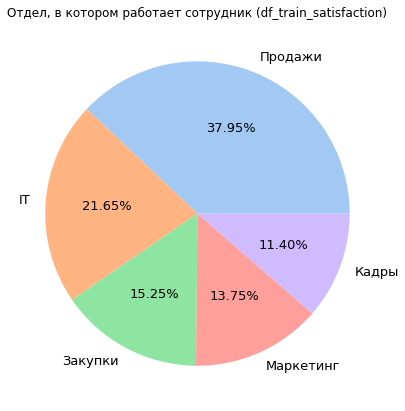

In [12]:
pie_chart(
    df_train_satisfaction['dept'],
    ['Продажи', 'IT', 'Закупки', 'Маркетинг', 'Кадры'],
    f'Отдел, в котором работает сотрудник '
    f'(df_train_satisfaction)'
)

В тренировочном датафрейме содержится информация о 4000 сотрудниках, из которых 38% работают в отделе продаж, 21.6% в  ИТ, 15.3% в отделе закупок, 13.8%  в отделе маркетинга и 11.4%  в отделе кадров. 

Рассмотрим аналогичный столбец в датафрейме с тестовыми данными.

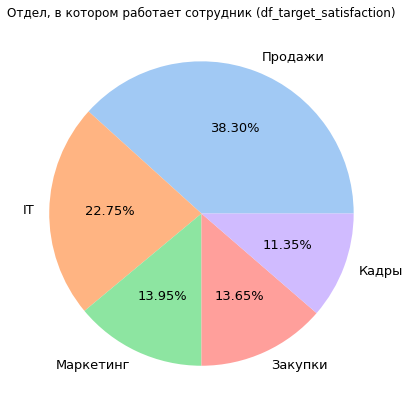

In [13]:
pie_chart(
    df_target_satisfaction['dept'],
    ['Продажи', 'IT', 'Маркетинг', 'Закупки', 'Кадры'],
    f'Отдел, в котором работает сотрудник '
    f'(df_target_satisfaction)'
)

В датафрейме с тестовыми данныминаходится информация о 2000 сотрудниках: 38.3% работают в отделе продаж, 22.8%  - в отделе ИТ, 14% - в маркетинговом отделе, 13.7% - в отделе закупок и 11.3% - в отделе кадров.

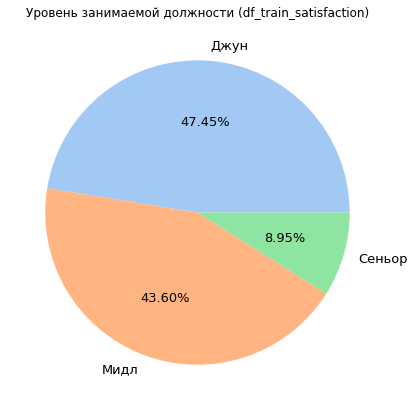

In [14]:
pie_chart(
    df_train_satisfaction['level'],
    ['Джун', 'Мидл', 'Сеньор'],
    f'Уровень занимаемой должности '
    f'(df_train_satisfaction)'
)

Из 4000 сотрудников подавлющее большисство джуны 47,4 % и мидлы 43,6 % , сеньоров немного 8,95 %.

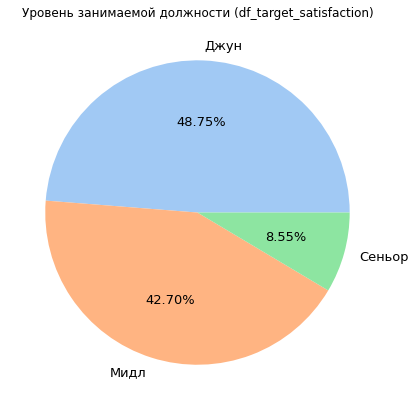

In [15]:
pie_chart(
    df_target_satisfaction['level'],
    ['Джун', 'Мидл', 'Сеньор'],
    f'Уровень занимаемой должности '
    f'(df_target_satisfaction)'
)

Из 2000 сотрудников подавлющее большисство джуны  48,8 % и мидлы 442,7 %, сеньоров немного 8,95 %.

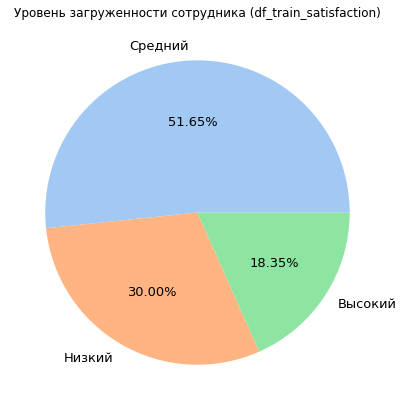

In [16]:
pie_chart(
    df_train_satisfaction['workload'],
    ['Средний', 'Низкий', 'Высокий'],
    f'Уровень загруженности сотрудника '
    f'(df_train_satisfaction)'
)

Из 4 000 сотрудников большая часть 51,6 %, имеет среднюю загрузку, 30 % имеют низкую загрузку, 18,4 % — высокую загрузку.

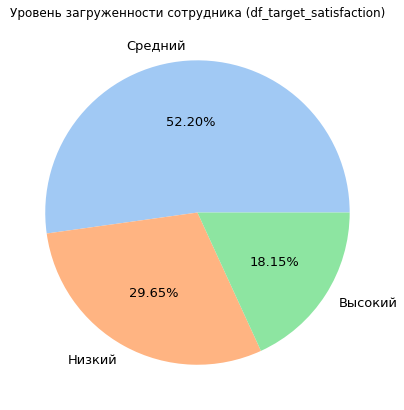

In [17]:
pie_chart(
    df_target_satisfaction['workload'],
    ['Средний', 'Низкий', 'Высокий'],
    f'Уровень загруженности сотрудника '
    f'(df_target_satisfaction)'
)

Из 2 000 сотрудников большая часть 52,2 % имеет среднюю загрузку, 29,6 % имеют низкую загрузку, 18,1 % — высокую загрузку.

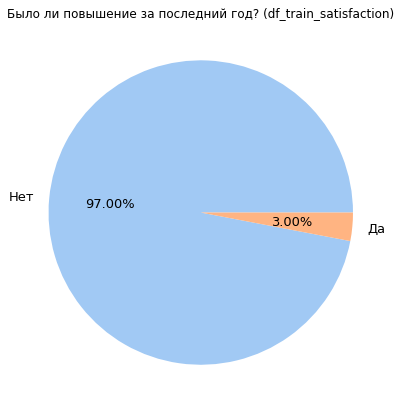

In [18]:
pie_chart(
    df_train_satisfaction['last_year_promo'],
    ['Нет', 'Да'],
    f'Было ли повышение за последний год? '
    f'(df_train_satisfaction)'
)

Из 4 000 сотрудников большая часть не получала повышения, только 3% перешли на более выскокую должность.

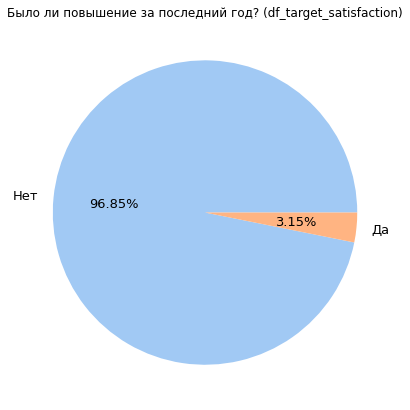

In [19]:
pie_chart(
    df_target_satisfaction['last_year_promo'],
    ['Нет', 'Да'],
    f'Было ли повышение за последний год? '
    f'(df_target_satisfaction)'
)

Из 2 000 сотрудников большая часть не получала повышения, только чуть больше 3% перешли на более выскокую должность.

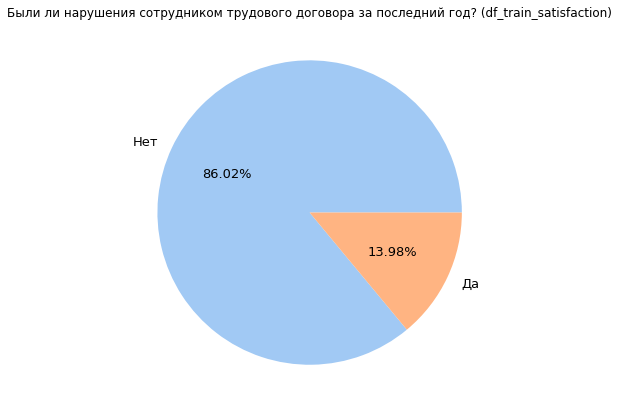

In [20]:
pie_chart(
    df_train_satisfaction['last_year_violations'],
    ['Нет', 'Да'],
    f'Были ли нарушения сотрудником трудового договора за последний год? '
    f'(df_train_satisfaction)'
)

Из 4 000 сотрудников 14 % сотрудников за последний год нарушили трудовой договор, а 86 % не имели нарушений.

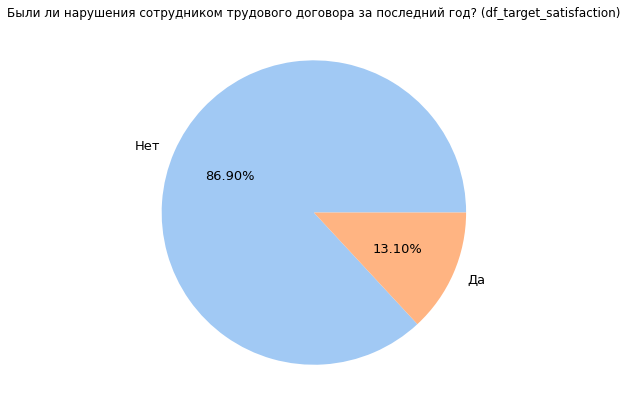

In [21]:
pie_chart(
    df_target_satisfaction['last_year_violations'],
    ['Нет', 'Да'],
    f'Были ли нарушения сотрудником трудового договора за последний год? '
    f'(df_target_satisfaction)'
)

Из 2 000 сотрудников 13,1 % сотрудников за последний год нарушили трудовой договор, а 86,9 % не имели нарушений.

Теперь рассмотрим столбцы с количественными данными. Также воспользовавшись функцией.

### Количественные показатели

Пора перейти к количесвтенным показтелям. К ним больше подойдут гистограммы для визулизации и последующего анализа.

Как в случае с даиграммами прибегнем к функции для большей читаемости.

In [22]:
def num_vis(df, col, xlabel, title,):
    plt.figure(figsize=(17, 5))
    sns.set_theme(palette="pastel")
    sns.histplot(
        df[col],
        bins = 20
    ).set(
        title = title,
        xlabel = xlabel,
        ylabel = 'Количество сотрудников')
    plt.show()

    plt.figure(figsize=(17, 3))
    sns.boxplot(
        df[col], 
        orient='h'
    ).set(
        title = title,
        xlabel = xlabel,
        )
    plt.show()
    
    display( df[col].describe())

Так как `employment_years` и `supervisor_evaluation` являются дискретными признаками, дополнительно для них построим круговые диаграммы.

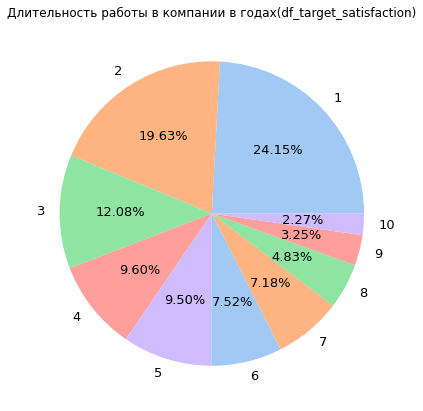

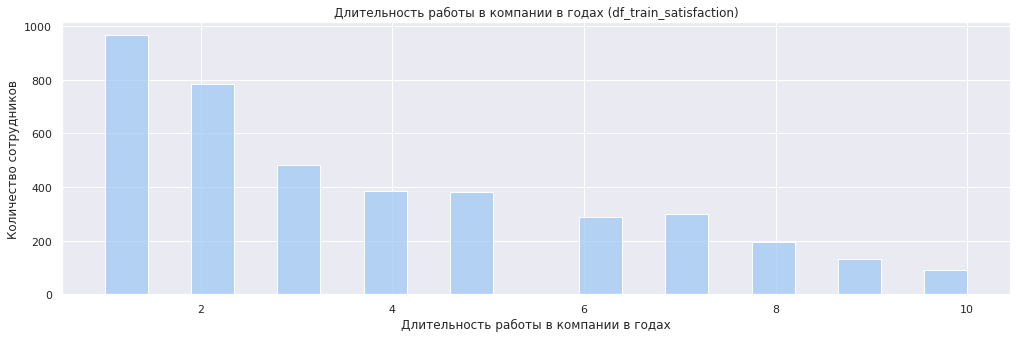

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


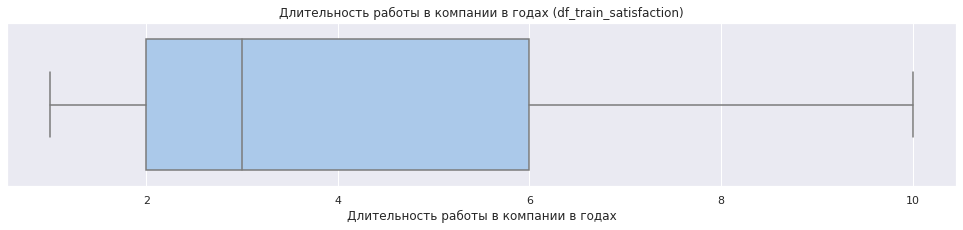

count   4,000.000
mean        3.719
std         2.543
min         1.000
25%         2.000
50%         3.000
75%         6.000
max        10.000
Name: employment_years, dtype: float64

In [23]:
pie_chart(
    df_train_satisfaction['employment_years'],
    [1,2,3,4,5,6,7,8,9,10],
    f'Длительность работы в компании в годах'
    f'(df_target_satisfaction)'
)

num_vis(
    df_train_satisfaction,
    'employment_years', 
    'Длительность работы в компании в годах',
    f'Длительность работы в компании в годах '
    f'(df_train_satisfaction)'
)

Все 4000 сотрудников работают в компании от 1 года до 10 лет. Средний срок работы составляет 3,719 года, медиана - 3 года.

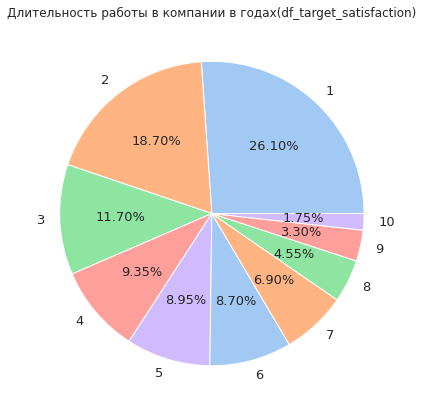

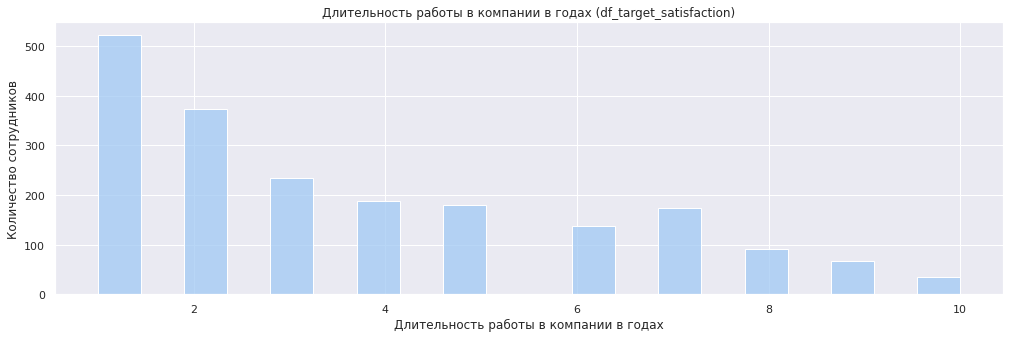

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


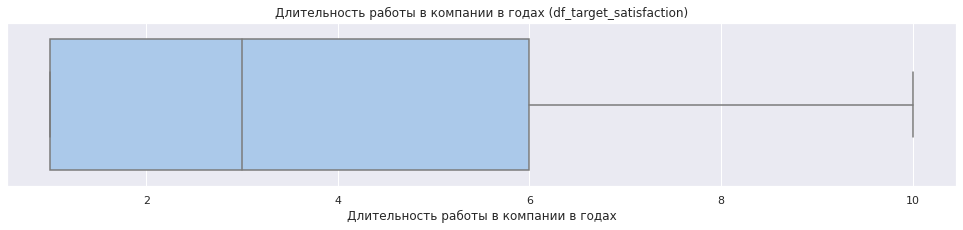

count     2000
unique      10
top          1
freq       522
Name: employment_years, dtype: int64

In [24]:
pie_chart(
    df_target_satisfaction['employment_years'],
    [1,2,3,4,5,6,7,8,9,10],
    f'Длительность работы в компании в годах'
    f'(df_target_satisfaction)'
)

num_vis(
    df_target_satisfaction,
    'employment_years', 
   'Длительность работы в компании в годах',
    f'Длительность работы в компании в годах '
    f'(df_target_satisfaction)'
)

Тестовые данные имеют аналогичное распределение: 2000 сотрудников работают в компании от 1 до 10 лет. Средний стаж работы составляет 3,667 года (или 3 года и 243 дня), медиана - 3 года.

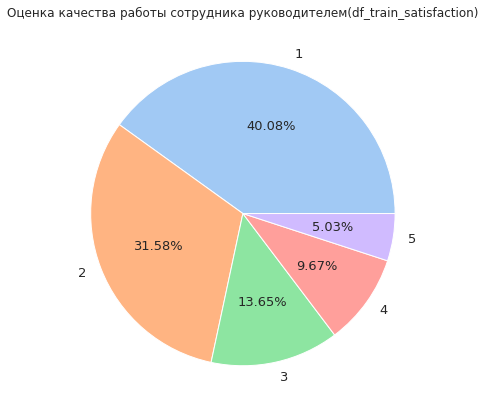

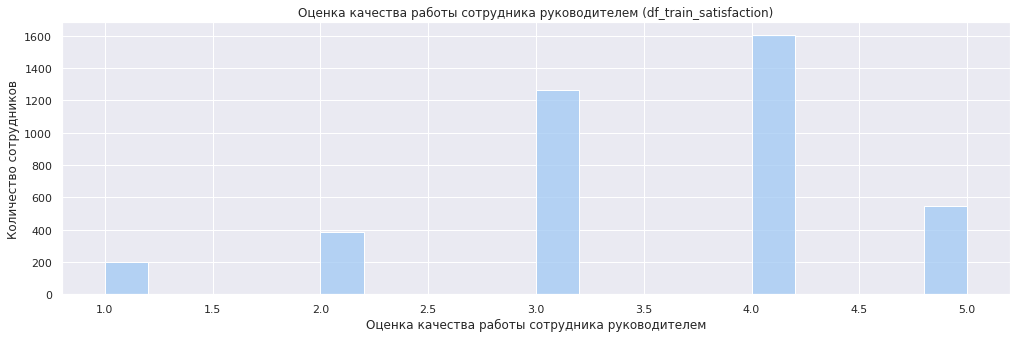

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


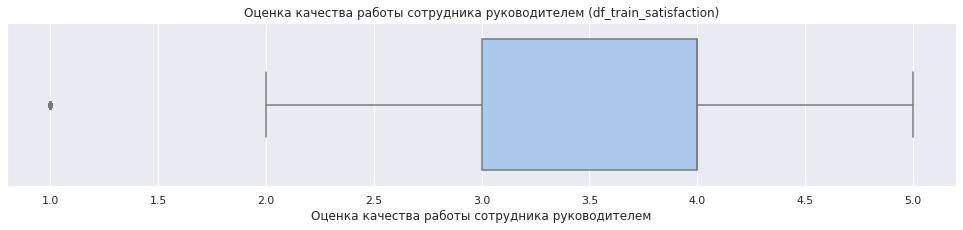

count   4,000.000
mean        3.477
std         1.009
min         1.000
25%         3.000
50%         4.000
75%         4.000
max         5.000
Name: supervisor_evaluation, dtype: float64

In [25]:
pie_chart(
    df_train_satisfaction['supervisor_evaluation'],
    [1,2,3,4,5],
    f'Оценка качества работы сотрудника руководителем'
    f'(df_train_satisfaction)'
)


num_vis(
    df_train_satisfaction,
    'supervisor_evaluation', 
   'Оценка качества работы сотрудника руководителем',
    f'Оценка качества работы сотрудника руководителем '
    f'(df_train_satisfaction)'
)

Качество работы некоторых сотрудников имеет крайне низку оценку - 1. средняя оценка 4 000 сотрудников компании составила 3,477, медианная — 4.

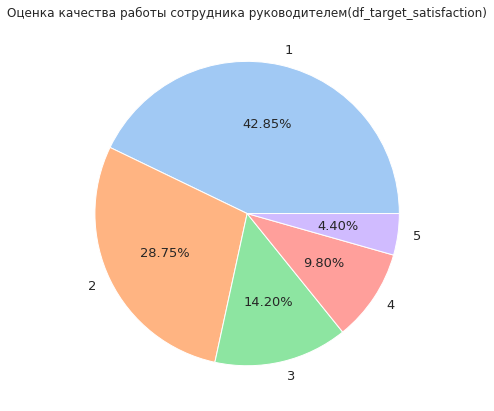

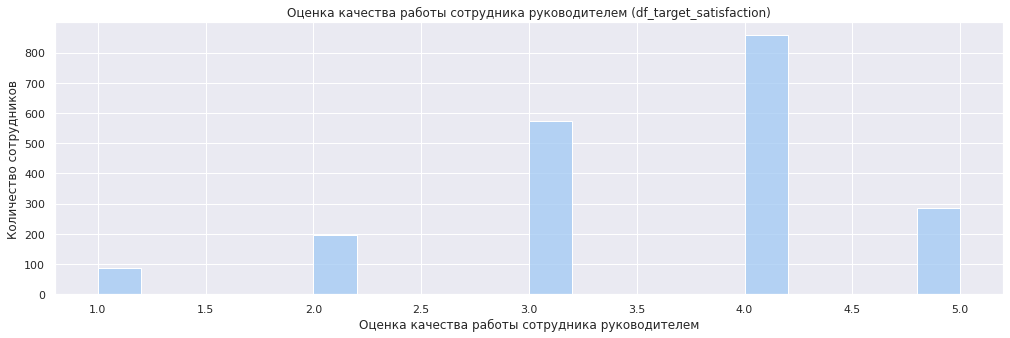

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


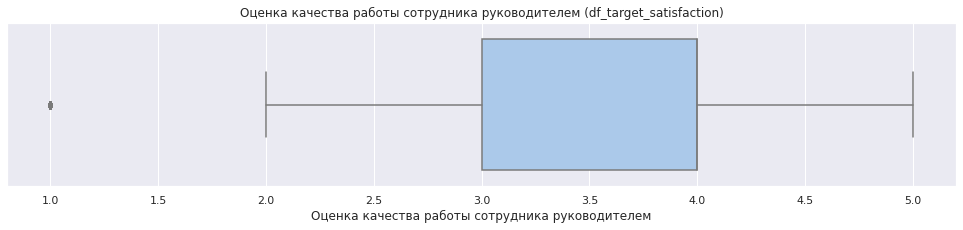

count     2000
unique       5
top          4
freq       857
Name: supervisor_evaluation, dtype: int64

In [26]:
pie_chart(
    df_target_satisfaction['supervisor_evaluation'],
    [1,2,3,4,5],
    f'Оценка качества работы сотрудника руководителем'
    f'(df_target_satisfaction)'
)


num_vis(
    df_target_satisfaction,
    'supervisor_evaluation', 
   'Оценка качества работы сотрудника руководителем',
    f'Оценка качества работы сотрудника руководителем '
    f'(df_target_satisfaction)'
)

Схожая история и в тестовой выборке: некоторые сотрудники получили оценку 1 от своих руководителей. Средняя оценка 2 000 сотрудников компании составила 3,526, медианная — 4. В тестовой выборке средняя оценка немного выше.

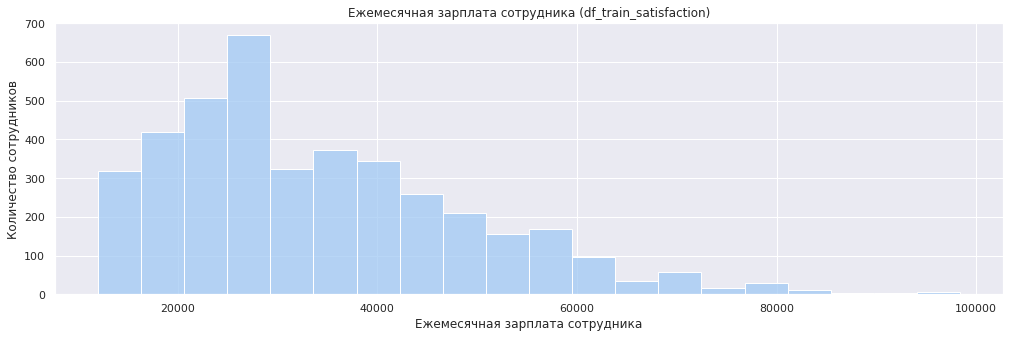

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


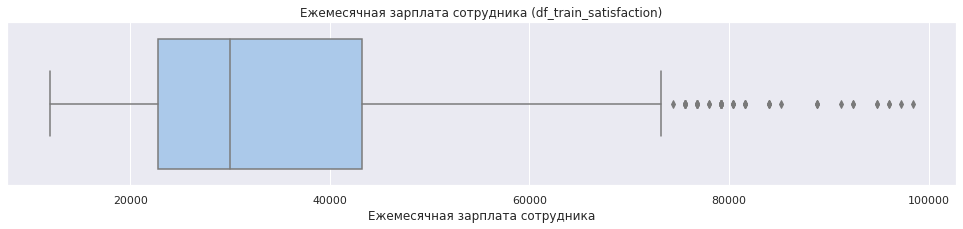

count    4,000.000
mean    33,926.700
std     14,900.704
min     12,000.000
25%     22,800.000
50%     30,000.000
75%     43,200.000
max     98,400.000
Name: salary, dtype: float64

In [27]:
num_vis(
    df_train_satisfaction,
    'salary', 
   'Ежемесячная зарплата сотрудника',
    f'Ежемесячная зарплата сотрудника '
    f'(df_train_satisfaction)'
)

Средняя зарплата на 4000 работников составляла 33 926,7 ₽, медианная - 30000₽. Минимальная - 12 000₽, максимальная - 984 00₽. Хоть у нас и есть необычные значения, мы не убираем их, потому что они не являются аномалиями.

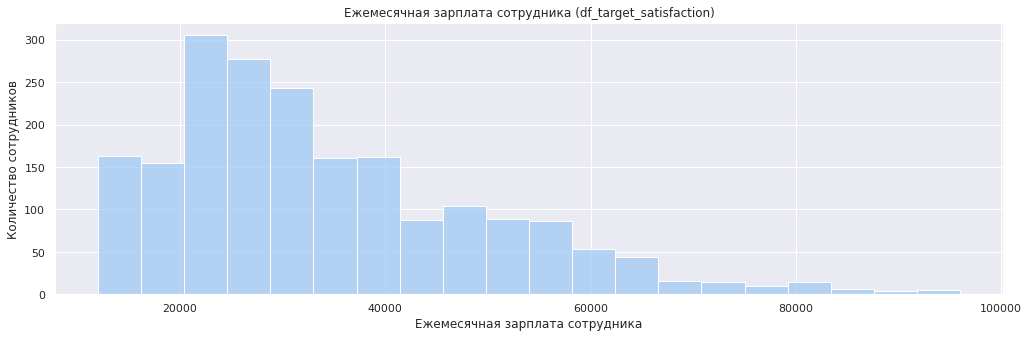

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


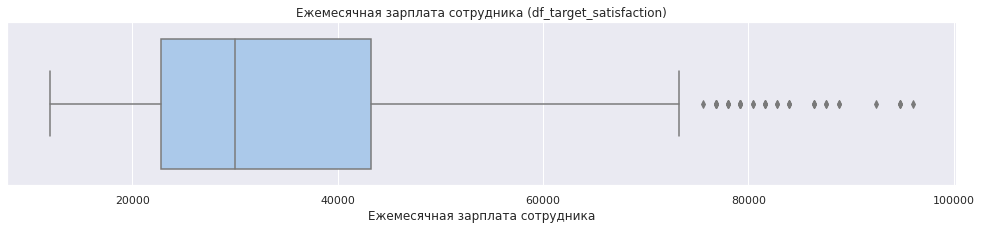

count      2000
unique       66
top       27600
freq        109
Name: salary, dtype: int64

In [28]:
num_vis(
    df_target_satisfaction,
    'salary', 
   'Ежемесячная зарплата сотрудника',
    f'Ежемесячная зарплата сотрудника '
    f'(df_target_satisfaction)'
)

Средняя зарплата 2000 сотрудников из тестовой выборки составила 34 066,8 ₽, медиана – 30 000 ₽. Минимальный оклад – 12 000 ₽, максимальный – 96 000 ₽. Хоть в данных и присутствуют необычные значения, их нельзя отбросить, так как они не являются аномальными.

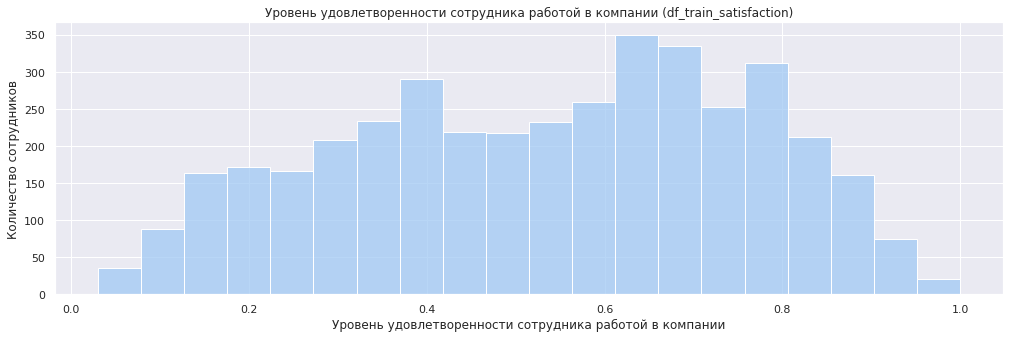

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


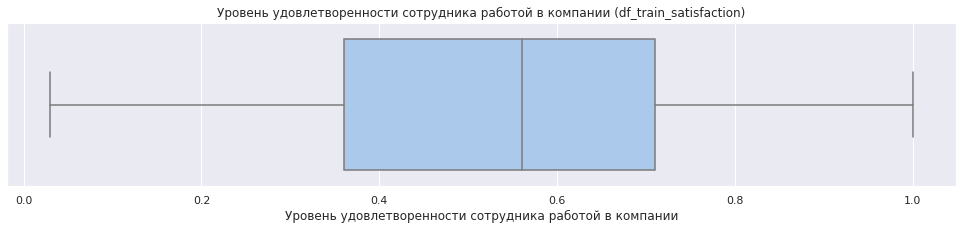

count   4,000.000
mean        0.534
std         0.225
min         0.030
25%         0.360
50%         0.560
75%         0.710
max         1.000
Name: job_satisfaction_rate, dtype: float64

In [29]:
num_vis(
    df_train_satisfaction,
    'job_satisfaction_rate', 
   'Уровень удовлетворенности сотрудника работой в компании',
    f'Уровень удовлетворенности сотрудника работой в компании '
    f'(df_train_satisfaction)'
)

Уровень удовлетворенности 4000 сотрудников работой в компании варьируется от 0.03 до 1, со средним значением 0.534 и медианным 0.56. Если перевести эти цифры в слова, то на вопрос “довольны ли вы своей работой в компании?” большинство сотрудников ответит “не знаю”.

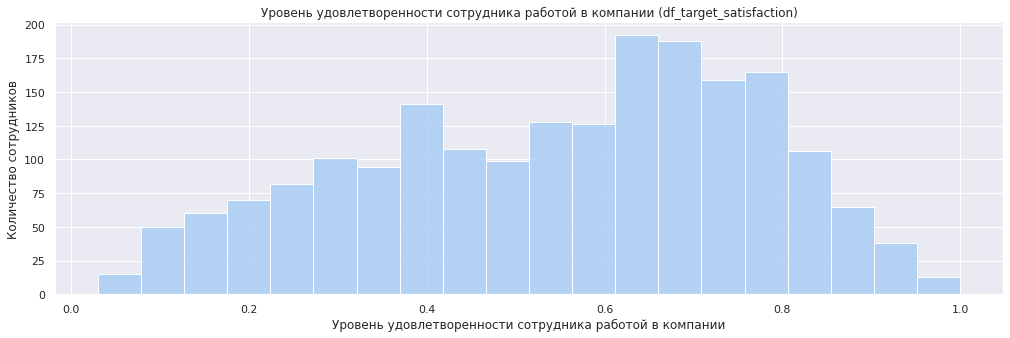

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


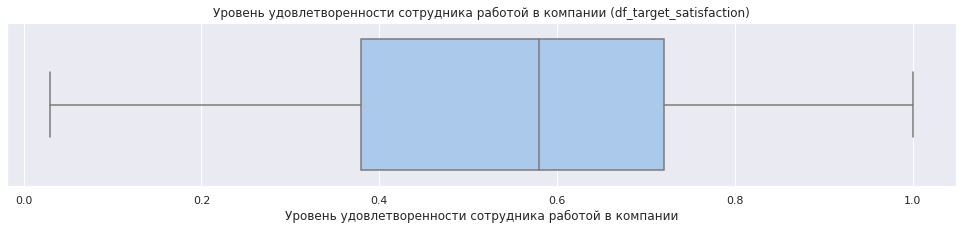

count    2,000.000
unique      98.000
top          0.700
freq        49.000
Name: job_satisfaction_rate, dtype: float64

In [30]:
num_vis(
    df_target_satisfaction,
    'job_satisfaction_rate', 
   'Уровень удовлетворенности сотрудника работой в компании',
    f'Уровень удовлетворенности сотрудника работой в компании '
    f'(df_target_satisfaction)'
)

Уровень удовлетворенности 2000 сотрудников работой в в тестовой выборке чуть выше, хотя минимальное значение по-прежнему составляет 0,03. Среднее — 0,549, медианное — 0,58.

### Корреляционный анализ

Построим матрицы корреляции с использованием функционала библиотеки `phik` и функции. Для двух датафремйов

In [31]:
def cor_mat(data, cols, title):
    plt.figure(figsize = (18, 6))
    sns.heatmap(
        data.phik_matrix(interval_cols = cols),
    annot = True,
    cmap = 'viridis'
    )
    plt.title(f'Матрица корреляции с тепловой картой '
        f'({title})'
             )
    plt.show()

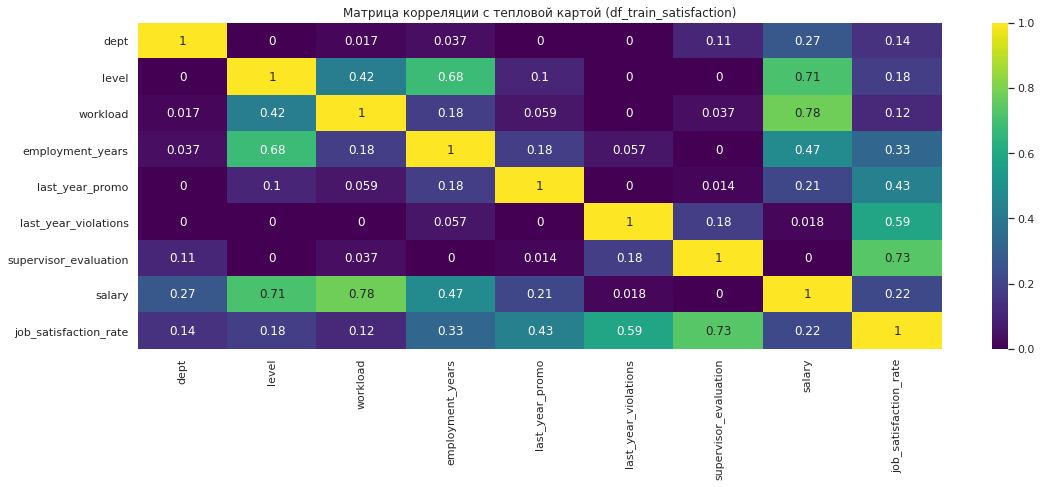

In [32]:
cor_mat(
    df_train_satisfaction.drop(['id'],axis = 1),
    ['salary'],
    'df_train_satisfaction'
)

Мы видим в основном слабую корреляцию между целевым признаком и предикторами. Однако, в случае с `last_year_violations` можно говорить о заметной корреляции (0.59), а в случае с `last_year_promo` - об умеренной. Корреляция между `supervisor_evaluation` и целевым признаком высокая (0.73). Корреляция между `level` и `salary` высокая (0.71), между `workload` и `salary` - высокая (0.78), между level и employment_years - заметная (0.68), между salary и employment_years умеренная (0.47). Также мы видим умеренную корреляцию между `level` и `workload` (0.42), которая указывает на мультиколлинеарность. 

Теперь посмотрим на аналогичную корреляционную матрицу для тестовой выборки.



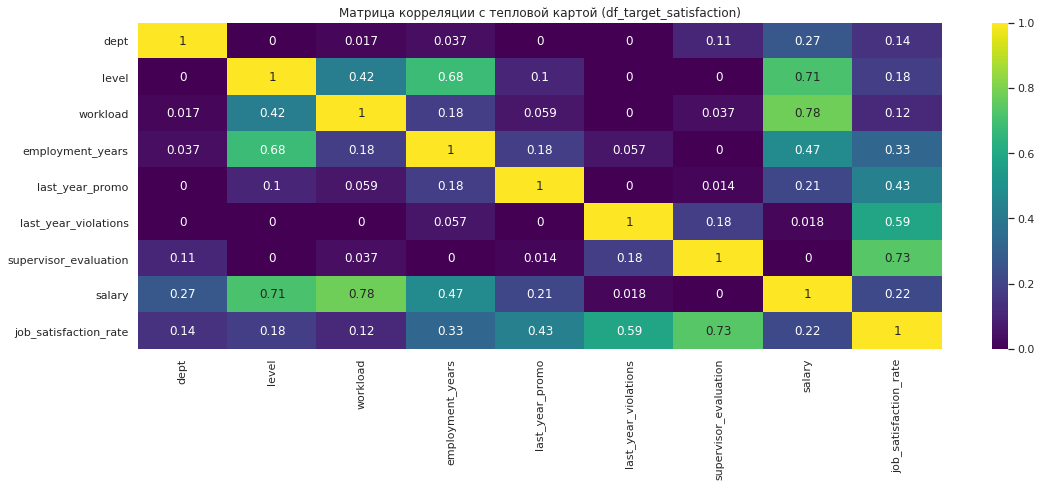

In [33]:
cor_mat(
     df_train_satisfaction.drop(['id'],axis = 1),
    ['salary'],
    'df_target_satisfaction'
)

Мы видим схожую картину и в тестовых данных. В основном мы наблюдаем слабую корреляцию между целевым признаком и предикторами, однако в случае с колонками last_year_promo и last_year_violations мы видим заметную корреляцию (0,53 и 0,58). Аналогично, в колонке employment_years мы видим умеренную корреляцию (0,34). Как и прежде, высокая корреляция наблюдается только между superviso_evaluation и целевым признаком (0,74). Вновь мы видим высокую корреляцию между уровнем и зарплатой (0,74) и между нагрузкой и зарплатой (0,78). Заметная корреляция присутствует между уровнем и стажем работы (0,69). Умеренная корреляция есть между зарплатой и стажем (0,50) и между уровнем и нагрузкой (0,47). Все это указывает на наличие мультиколлинеарности.

Изучив все столбцы в трех датафреймах обнаружили, что средний сотрудник в обучающих и тестовых данных имеет одинаковые характеристики, поэтому результаты, полученные после обучения на обучающих данных, могут быть использованы для работы с тестовыми данными. Мы планируем кодировать информацию в столбцах с помощью `OneHotEncoder` и `OrdinalEncoder` и масштабировать ее с помощью `RobustScaler` (который устойчив к выбросам данных) и `MinMaxScaler`. Средний сотрудник работает в компании на должности джуна в отделе продаж или ИТ, имеет среднюю нагрузку, за прошедший год не получил повышения или нарушения трудового договора. Этот сотрудник работает в компании 3.719 года (3.667 в тестовой выборке), его зарплата составляет 33,926.7 рублей (34,066.8 в тестовой выборке) в месяц и оценка его работы его руководителем составляет 3.477 (3.526 в тестовой выборке). Уровень удовлетворенности работой данного сотрудника составляет 0.534 (0,549 в тестовой выборке).

## Подготовка данных

Выполним подготовку данных для обучения моделей.

Сначала сохраним предикторы и целевой показатель отдельно. Так как у нас уже есть два отдельных датасета, нам не нужно разбивать данные с помощью `train_test_split`. Затем создадим список столбцов для кодировщиков. 

В OneHotEncoder передадим данные из столбцов `dept` (один из пяти возможных вариантов), `last_year_promo` и `last_year_violations` (одно из двух возможных значений, двоичный признак). 

В `OrdinalEncoder` передадим данные из столбцов `leve` и `workload`. В этих столбцах одно из трех возможных значений, которое может быть ранжировано (уровень должности - джунг, мидл или сеньор; уровень нагрузки - низкий, средний или высокий). Мы заметили опечатку в уровне должности `senior`, но не исправили ее, так как она присутствует в трех датасетах, так что проблем с кодированием не должно возникнуть.

Мы будем использовать `RobustScaler` для масштабирования данных в столбце `salary`, который устойчив к выбросам. Для двух других количественных признаков (e`mployment_years` и `supervisor_evaluation`) мы будем использовать `MinMaxScaler`. Перед разделением данных на предикторы и целевой атрибут в обучающем наборе мы должны убедиться, что после удаления строки с `id` не дублируются.

In [34]:
print(
    f'Количество дубликатов в датафрейме df_train_satisfaction '
    f'до манипуляций: '
    f"{df_train_satisfaction.drop('id', axis = 1).duplicated().sum()}",
)

df_train_satisfaction = df_train_satisfaction.drop('id', axis = 1).drop_duplicates()

print(
    f'Количество дубликатов в датафрейме df_train_satisfaction '
    f'после манипуляций: '
    f'{df_train_satisfaction.duplicated().sum()}'
)

Количество дубликатов в датафрейме df_train_satisfaction до манипуляций: 248
Количество дубликатов в датафрейме df_train_satisfaction после манипуляций: 0


In [35]:
#Задаем тренировочные данные.
X_train_model_1 = df_train_satisfaction.drop(['job_satisfaction_rate'], axis = 1)
y_train_model_1 = df_train_satisfaction['job_satisfaction_rate']

#Задаем тестовые данные.
X_test_model_1 = df_target_satisfaction.drop(['job_satisfaction_rate'], axis = 1)
y_test_model_1 = df_target_satisfaction['job_satisfaction_rate']

#Задаем списки столбцов для кодирования и масштабирования.
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
big_num = ['salary']
num_columns = ['employment_years', 'supervisor_evaluation']

#Пайплайн подготовки признаков с помощью OneHotEncoder.
ohe_pipe = Pipeline(
    [
        (
            'ohe',
            OneHotEncoder(
                drop = 'first',
                sparse_output = False
            )
        )
    ]
)

In [36]:
#Пайплайн подготовки признаков с помощью OrdinalEncoder.
ord_pipe = Pipeline(
    [
        (
            'ord',
            OrdinalEncoder(categories = [
                ['junior', 'middle', 'sinior'],
                ['low', 'medium', 'high']
            ]
                          )
        )
    ]
)

In [37]:
#Общий пайплайн подготовки данных.
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('big_num', RobustScaler(), big_num),
    ('num_scaling', MinMaxScaler(), num_columns)
])

#Производим обучение.
data_preprocessor.fit(X_train_model_1, y_train_model_1)

#Создаем список с новыми названиями столбцов в датафреймах.
new_columns = data_preprocessor.get_feature_names_out()

In [38]:

#Сохраняем кодированные и масштабированные данные.
X_train_model_1 = pd.DataFrame(
    data_preprocessor.transform(X_train_model_1),
    columns = new_columns
)

X_test_model_1 = pd.DataFrame(
    data_preprocessor.transform(X_test_model_1),
    columns = new_columns
)

Мы подготовили обучающие и тестовые данные для моделей. Качественные переменные были преобразованы с помощью `OneHotEncoder` и `OrdinalEncoder`, а количественные - с помощью `RobustScaler` и `MinMaxScaler`. Наши данные готовы к передаче в конвейер с моделями.

## Обучение моделей и выбор лучшей из них

На этом этапе мы будем использовать пайплайн для поиска оптимальной модели. Так как мы имеем дело с непрерывной целевой переменной, то наша задача - регрессия. В качестве моделей мы используем `DecisionTreeRegresso` и `LinearRegression`, а в качестве метода подбора - `GridSearchCV`.

Для оценки качества моделей мы создаем метрику `SMAPE` согласно заданию. Формула `SMAPE`, приведенная в задании, отличается от канонической, но результаты обеих формул будут одинаковыми, потому что все значения берутся по модулю. В канонической формуле вместо $|{y_i} - \hat{y_i}|$ стоит $|\hat{y_i} - {y_i}|$ .

В одном предложении упоминалось, что если выбрать параметр `greater_is_better = False`, метод `make_scorer` изменит знак значения метрики на противоположный. Мы учтем это при выводе метрик модели.

In [39]:
def smape_calculation(y_actual, y_forecast):
    smape_score = (
        (
            abs(y_actual - y_forecast)
            / (
                (abs(y_actual) + abs(y_forecast))
                / 2
            ) * 100
        ).mean()
    )
    return smape_score
smape = make_scorer(smape_calculation, greater_is_better = False)

Теперь создаем пайплайн по поиску модели и запускаем его.

In [40]:
RANDOM_STATE = 42

reg_models_pipe = Pipeline(
    [('models', DecisionTreeRegressor(random_state = RANDOM_STATE))]
)

In [41]:
# Словари для моделей.
param_grid = [
    # Словарь для модели DecisionTreeRegressor().
    {
        'models' : [DecisionTreeRegressor(random_state = RANDOM_STATE)],
        'models__max_depth' : [3, 5, 15, 25],
        'models__max_features' : [3, 5, 10],
        'models__min_samples_split' : [3, 5, 10]
    },
    # Пустой словарь для модели LinearRegression().
    {
        'models': [LinearRegression()]
    }
]

In [42]:
# Задаем настройки поиска оптимальных параметров.
model_search_1 = GridSearchCV(
    reg_models_pipe,
    param_grid,
    scoring = smape,
    n_jobs = -1
)

# Производим поиск оптимальных параметров модели.
model_search_1.fit(X_train_model_1, y_train_model_1)

# Выводим лучшую модель.
print(
    f'Лучшая модель и ее параметры:\n\n {model_search_1.best_estimator_} \n\n')

# Выводим абсолютное значение SMAPE для тренировочных данных.
print(
    f'Метрика SMAPE лучшей модели на тренировочной выборке: '
    f'{abs(model_search_1.best_score_):,.2f}'
    .replace('.', ','),
    end = '.\n'
)

Лучшая модель и ее параметры:

 Pipeline(steps=[('models',
                 DecisionTreeRegressor(max_depth=25, max_features=10,
                                       min_samples_split=10,
                                       random_state=42))]) 


Метрика SMAPE лучшей модели на тренировочной выборке: 15,21.


Сохраним полученную модель, передадим ей тестовые данные для вычисления предсказаний целевого признака и расчитаем значение `SMAPE` для этих данных.

In [43]:
model_exercise_1 = model_search_1.best_estimator_

y_model_forecast_1 = model_exercise_1.predict(X_test_model_1)

print(
    f'Метрика SMAPE лучшей модели на тестовой выборке: '
    f'{smape_calculation(y_test_model_1, y_model_forecast_1):,.2f}'
)

Метрика SMAPE лучшей модели на тестовой выборке: 13.65


Согласно заданию, критерием успешности является значение `SMAPE` меньше или равное 15. Таким образом, мы нашли подходящую модель для предсказания уровня удовлетворения сотрудника работой в компании. 

Был проведен поиск по сетке параметров для двух моделей (линейная регрессия и дерево решений). В результате работы конвейера мы получили лучшую модель `DecisionTreeRegressor` с следующими гиперпараметрами: `max_depth=25`, `max_features=10`, `min_samples_split=10`. Значение метрики `SMAPE` для тестовых данных равно 13.65.

## Промежуточные выводы


Мы установили и загрузили библиотеки, модули и подмодули, загрузили данные и сохранили их в виде датасетов. Визуальный анализ выявил наличие небольшого количества пропущенных значений в двух датасетах.

Мы обработали пропущенные значения в данных, полученных от заказчика, также удалили пустые значения и заполнили отсутствующие значения в столбцах с помощью `SimpleImputer`. Затем мы объединили `df_test` и `df_test_satisfaction`, и дубликатов не обнаружилось.

По результатам исследовательского анализа данных мы определили, что средний сотрудник в обучающей и тестовой выборках имеет одинаковые характеристики, поэтому результаты, полученные после обучения на обучающей выборке, могут быть применены к тестовой выборке. Средний сотрудник работает в компании на позиции джуна в отделе продаж или IT, имеет среднюю нагрузку, в прошлом году не получил повышения или нарушения трудового договора. Этот сотрудник работает в компании 3.719 года (в тестовой выборке - 3.667), его зарплата составляет 33,926.7 ₽ (в тестовой выборке 34,066.8 ₽), оценка его работы начальником - 3.477 (в тестовой выборке 3.526). Уровень удовлетворенности сотрудника своей работой оценивается в 0.534 (в тестовой выборке 0.549). Мы также рассказали, какие инструменты планируем использовать для кодирования и масштабирования признаков.

Были подготовленны тренировоные и тестовые данные для моделей. Качественные признаки были преобразованы с использованием `OneHotEncoder` и `OrdinalEncoder`, а количественные признаки - с использованием `RobustScaler` и `MinMaxScaler`.

Мы провели поиск по сетке гиперпараметров для двух моделей: линейной регрессии и дерева принятия решений. В результате мы получили лучшую модель - `DecisionTreeRegressor` - со следующими гиперпараметрами: максимальная глубина дерева `max_depth = 25`, `max_features = 10`, `min_samples_split = 10`. Значение метрики `SMAPE` для тестовых данных составило 13,65.

# Предсказание увольнения сотрудника из компании

## Загрузка данных.

Мы выполнили загрузку и первичную оценку данных в начале работы над проектом. Повторное рассмотрение не требуется.

## Предобработка данных

Мы обработали данные датасета `df_test` ранее. В датасетах `df_train_quit` и `df_test_quit`, как мы уже установили, нет пропущенных значений, все значения столбцов соответствуют указанным типам данных и нет дубликатов.


## Исследовательский анализ данных

### Качественные показатели

Для анализа данных в датасетах `df_train_qui`t и `df_test_quit` мы воспользуемся теми же функциями, чтои ранее в проекте. Анализ датасета `df_test` мы уже провели.

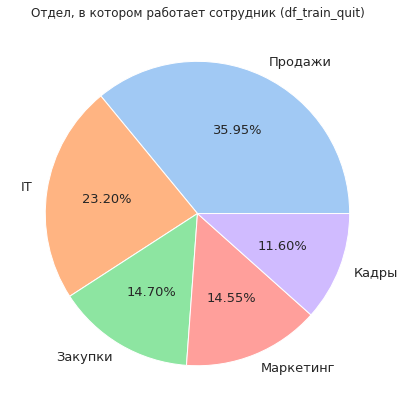

In [44]:
pie_chart(
    df_train_quit['dept'],
    ['Продажи', 'IT', 'Закупки', 'Маркетинг', 'Кадры'],
    f'Отдел, в котором работает сотрудник '
    f'(df_train_quit)'
)

В тренировочном датасете содержится информация о 4000 сотрудниках. Из них 35.9%  работают в отделе продаж, 23.2% (928 сотрудников) - в отделе ИТ, 14.7% - в отделе закупок, 14.5%  - в отделе маркетинга и 11.6%  - в отделе кадров. 

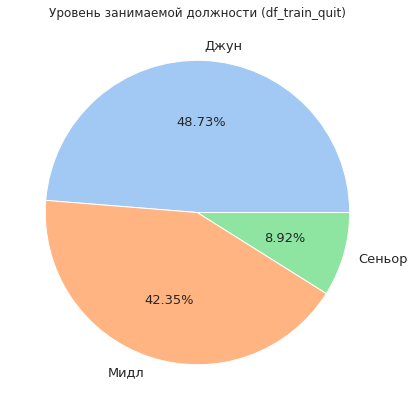

In [45]:
pie_chart(
    df_train_quit['level'],
    ['Джун', 'Мидл', 'Сеньор'],
    f'Уровень занимаемой должности '
    f'(df_train_quit)'
)

Из 4 000 сотрудников 48,7 %  работают на начальных позициях, 42,4 % — на средних позициях и 8,92 % — на старших позициях.

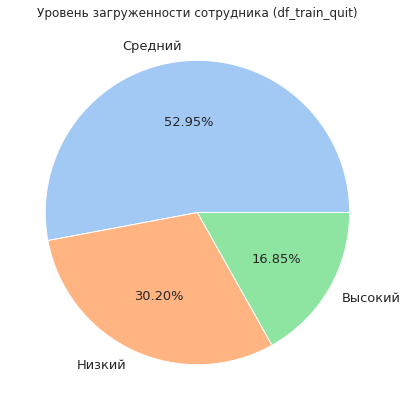

In [46]:
pie_chart(
    df_train_quit['workload'],
    ['Средний', 'Низкий', 'Высокий'],
    f'Уровень загруженности сотрудника '
    f'(df_train_quit)'
)

Из 4 000 сотрудников большая часть 52,9%, имеет среднюю загрузку, 30,2% имеют низкую загрузку, 16,9% имеют высокую загрузку.

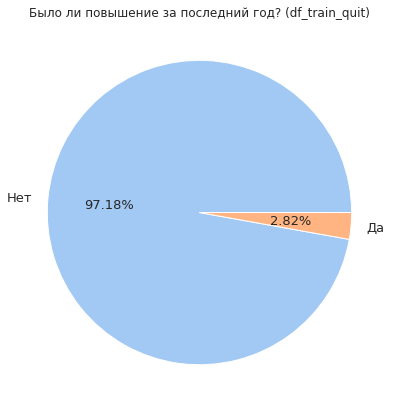

In [47]:
pie_chart(
    df_train_quit['last_year_promo'],
    ['Нет', 'Да'],
    f'Было ли повышение за последний год? '
    f'(df_train_quit)'
)

97,2% сотрудников не получили повышения в прошлом году и только  человек 2,8% перешли на более высокую должность.

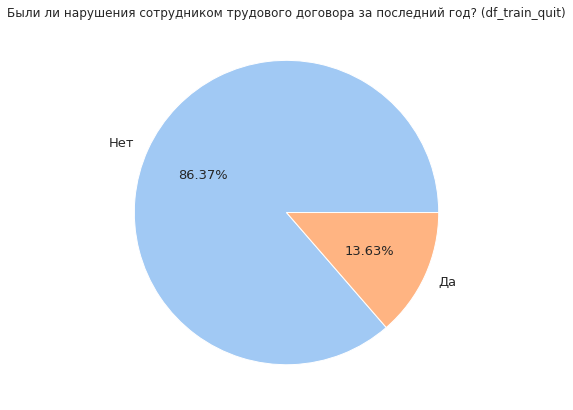

In [48]:
pie_chart(
    df_train_quit['last_year_violations'],
    ['Нет', 'Да'],
    f'Были ли нарушения сотрудником трудового договора за последний год? '
    f'(df_train_quit)'
)

13,6% сотрудников за последний год нарушили трудовой договор, а 86,4% не имели нарушений.

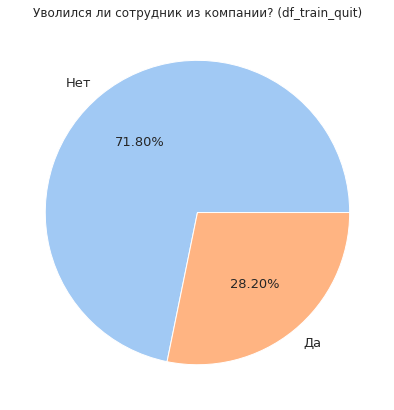

In [49]:
pie_chart(
    df_train_quit['quit'],
    ['Нет', 'Да'],
    f'Уволился ли сотрудник из компании? '
    f'(df_train_quit)'
)

Из 4 000 сотрудников в тренировочной выборке человек 28,2% уволились, а человека 71,8% остались работать в компании.

Расмотрим на аналогичные данные в тестовой выборке.

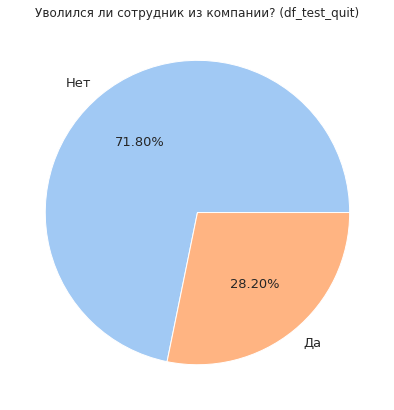

In [50]:
pie_chart(
    df_test_quit['quit'],
    ['Нет', 'Да'],
    f'Уволился ли сотрудник из компании? '
    f'(df_test_quit)'
)

Из 2 000 сотрудников в тренировочной выборке 28,2% уволились, а человек 71,8% остались работать в компании.

### Количественные показатели

Так как `employment_years` и `supervisor_evaluation` являются дискретными признаками, дополнительно для них построим круговые диаграммы.

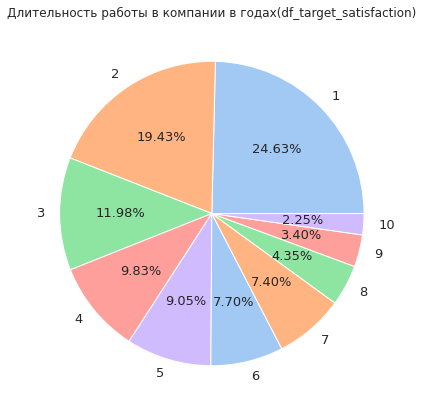

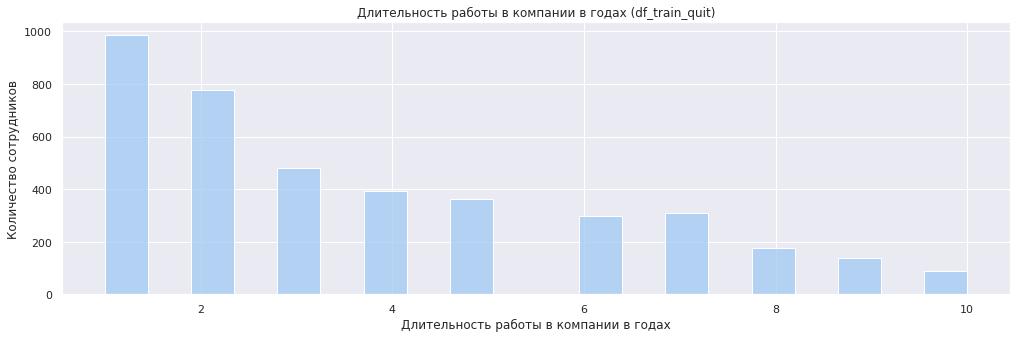

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


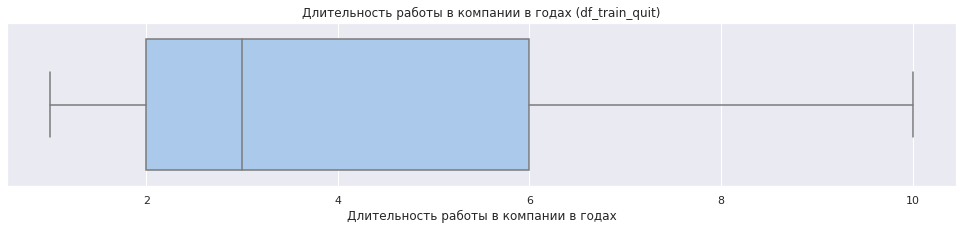

count   4,000.000
mean        3.701
std         2.542
min         1.000
25%         2.000
50%         3.000
75%         6.000
max        10.000
Name: employment_years, dtype: float64

In [51]:
pie_chart(
    df_train_quit['employment_years'],
    [1,2,3,4,5,6,7,8,9,10],
    f'Длительность работы в компании в годах'
    f'(df_target_satisfaction)'
)


num_vis(
    df_train_quit,
    'employment_years', 
    'Длительность работы в компании в годах',
    f'Длительность работы в компании в годах '
    f'(df_train_quit)'
)

Все 4 000 сотрудников трудятся в компании от 1 года до 10 лет. Среднее значение составляет 3,701 года (3 года 256 дней), медианное — 3 года.

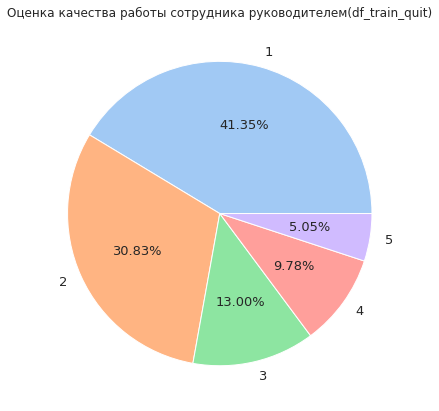

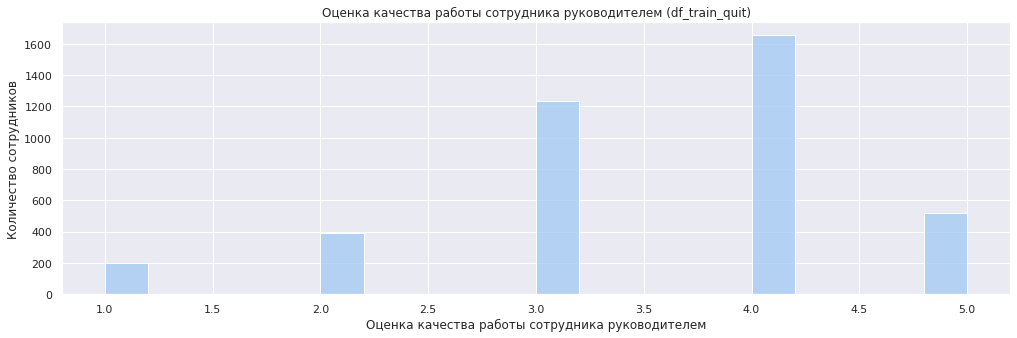

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


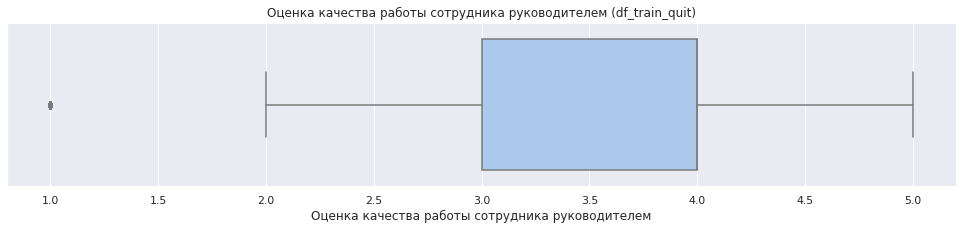

count   4,000.000
mean        3.475
std         1.004
min         1.000
25%         3.000
50%         4.000
75%         4.000
max         5.000
Name: supervisor_evaluation, dtype: float64

In [52]:
pie_chart(
    df_train_quit['supervisor_evaluation'],
    [1,2,3,4,5],
    f'Оценка качества работы сотрудника руководителем'
    f'(df_train_quit)'
)

num_vis(
    df_train_quit,
    'supervisor_evaluation', 
    'Оценка качества работы сотрудника руководителем',
    f'Оценка качества работы сотрудника руководителем '
    f'(df_train_quit)'
)

Некоторые сотрудники получили оценку 1 от своих руководителей, то есть их качество работы очень низкое. В то же время средняя оценка 4 000 сотрудников компании составила 3,475, медианная — 4.

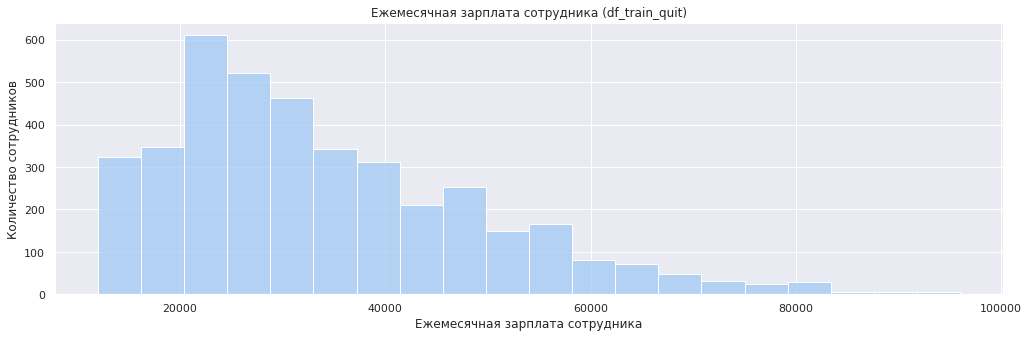

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


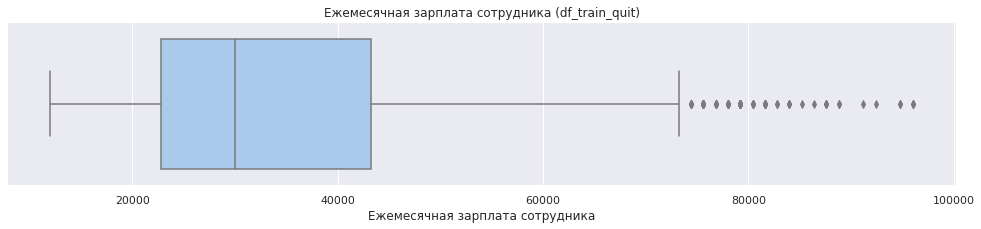

count    4,000.000
mean    33,805.800
std     15,152.415
min     12,000.000
25%     22,800.000
50%     30,000.000
75%     43,200.000
max     96,000.000
Name: salary, dtype: float64

In [53]:
num_vis(
    df_train_quit,
    'salary', 
    'Ежемесячная зарплата сотрудника',
    f'Ежемесячная зарплата сотрудника '
    f'(df_train_quit)'
)

Средyемесячная зарплата 4000 сотрудников составляет 33805.8 ₽ (медиана - 30000₽). Минимальная зарплата - 12000₽, максимальная - 96000₽. Несмотря на наличие выбросов, мы не можем удалить эти данные, так как они не являются аномальными. Теперь рассмотрим корреляционную матрицу признаков.

Посмотрим теперь на матрицу корреляции признаков.

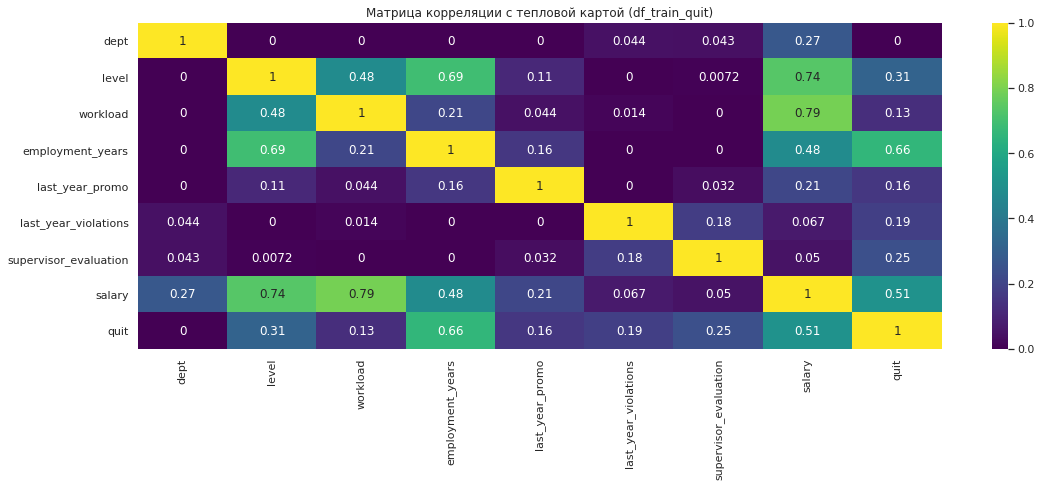

In [54]:
cor_mat(
    df_train_quit.drop(['id'],axis = 1),
    ['employment_years', 'salary'],
    'df_train_quit'
)

Мы видим в основном слабую корреляцию между целевым признаком и предикторами. Однако в случае с признаками `employment_years` и `salary` мы видим заметную корреляцию. Сильной корреляции не наблюдается. 

Как и в случае с датасетом df_train_satisfaction, у нас есть высокая корреляция между парами признаков `level` и `salary` (0.74), `workload` и `salary`, а также заметная корреляция между уровнем и продолжительностью работы, умеренная корреляция между зарплатой и продолжительностью работы, уровнем и рабочей нагрузкой. Это указывает на наличие мультиколлинеарности.

### Корреляционный анализ

Посмотрим на аналогичную матрицу корреляции для тестовой выборки.

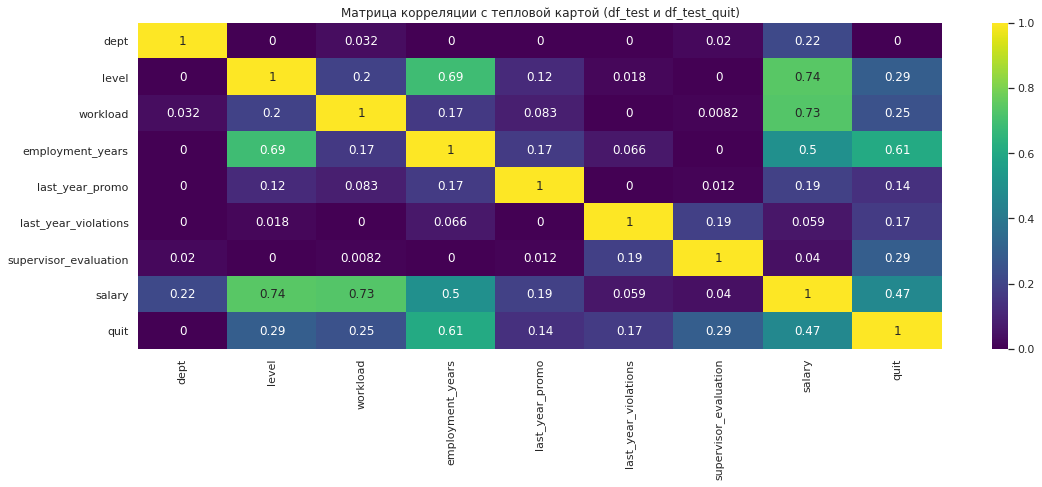

In [55]:
cor_mat(
    df_test.merge(df_test_quit, on = 'id').drop(['id'], axis = 1),
    ['salary'],
    'df_test и df_test_quit'
)

Мы видим аналогичную картину и для тестовых данных. В основном, наблюдается слабая корреляция между целевым признаком и предикторами. С данными в столбцах `employment_years` и `salary` наблюдается заметная и средняя корреляция. Сильной корреляции снова не наблюдается. 

Мы видим высокую корреляцию между парами предикторов `level` и `salary`, `workload` и `salary`, заметную корреляцию между `level` и `employment_years`, умеренную корреляцию между `salary` и `employment_years`, `level` и `workload`, что опять указывает нам на наличие мультиколлинеарности.

Давайте рассмотрим все столбцы данных в обоих датафреймах (`df_test` мы уже рассматривали ранее). Мы определили, что средние значения для сотрудников в обучающей и тестовой выборках совпадают, поэтому результаты, полученные после обучения на обучающей выборке, могут быть использованы для работы с тестовой. Мы планируем закодировать данные столбцов с помощью “OneHotEncoder” и `OrdinalEncoder`, масштабировать с помощью `RobustScaler` (устойчивый к выбросам данных) и `MinMaxScaler`. Средний сотрудник работает в компании на должности начального уровня в отделе продаж или ИТ, имеет среднюю нагрузку, в прошлом году не было повышений или нарушений трудового договора. Этот сотрудник работает в компании 3,701 года, его зарплата составляет 33 805,8 рублей в месяц, его оценка от руководителя равна 3,475. Если все остальные условия равны, то вероятность увольнения сотрудника составляет 28,2%.

### «Портрет» уволившегося сотрудника

Чтобы составить «портрет» уволившегося сотрудника посмотрим на различные столбцы с учетом значения в столбце `quit`.

Посмотрим на гистограммы количественных признаков с помощью функции.

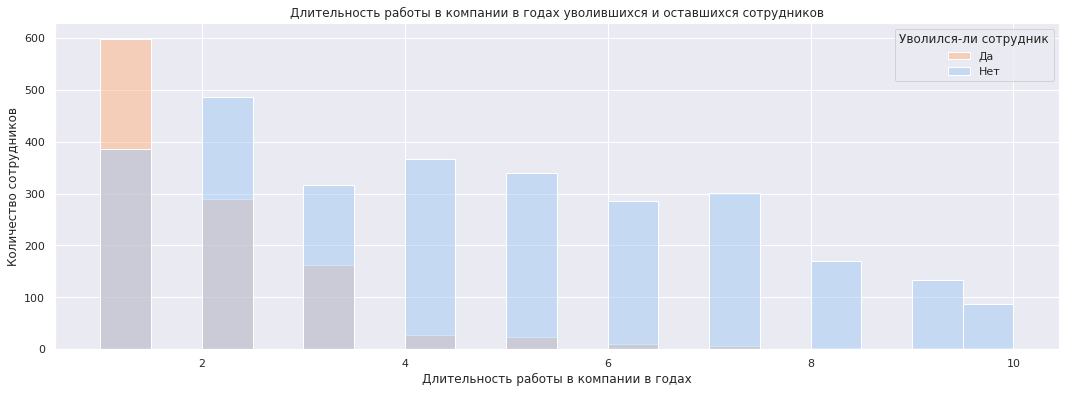

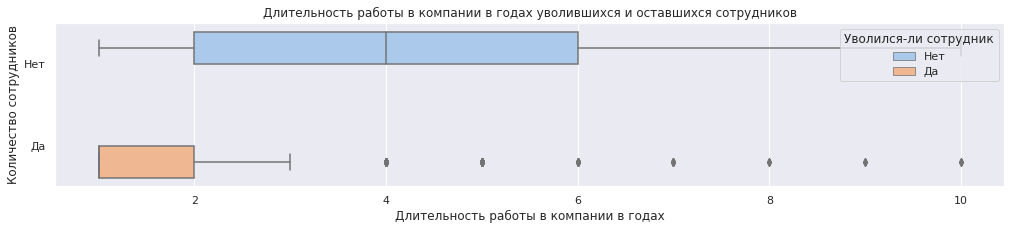

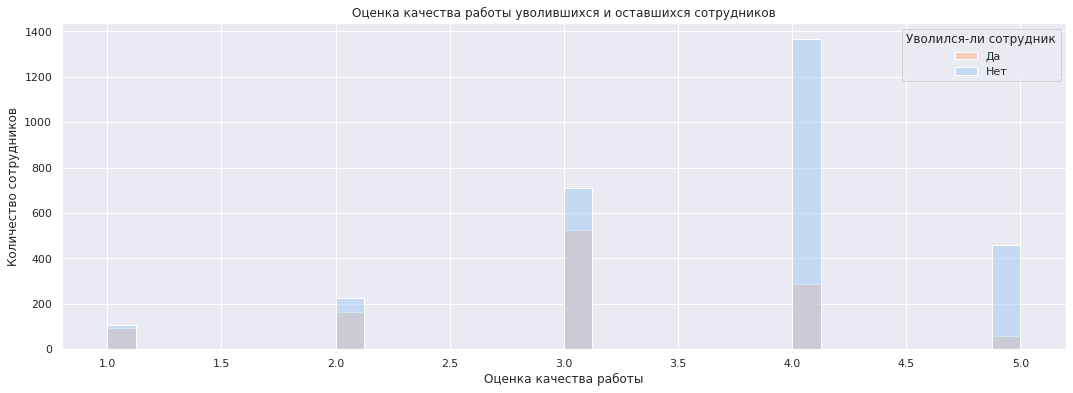

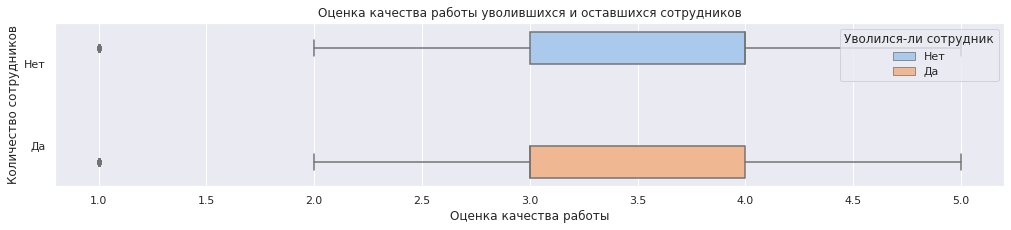

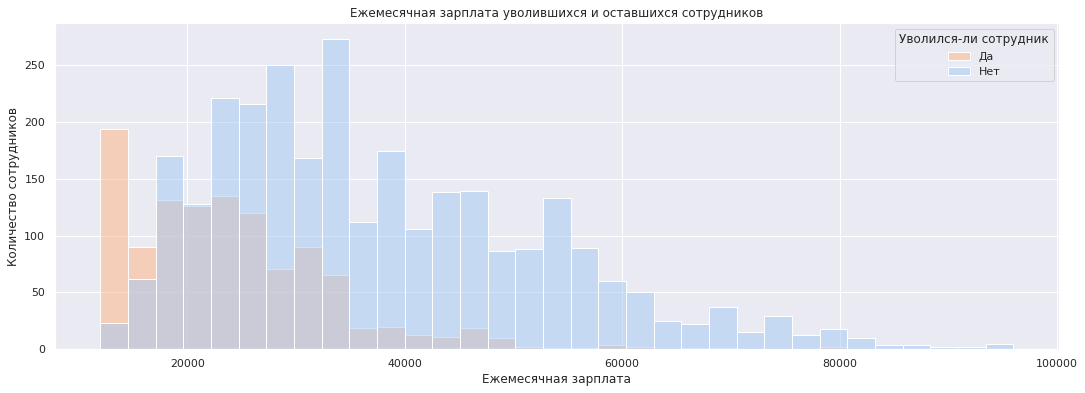

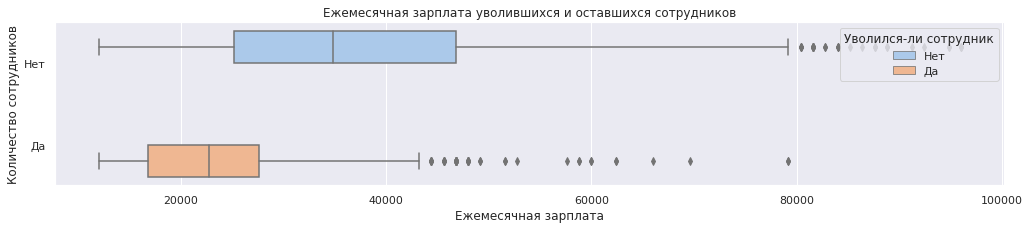

Уволившиеся сотрудники


,Длительность работы в компании в годах,Оценка качества работы,Ежемесячная зарплата
count,"1,128.000","1,128.000","1,128.000"
mean,1.845,3.046,"23,885.106"
std,1.275,0.973,"9,351.600"
min,1.000,1.000,"12,000.000"
25%,1.000,3.000,"16,800.000"
50%,1.000,3.000,"22,800.000"
75%,2.000,4.000,"27,600.000"
max,10.000,5.000,"79,200.000"



Оставшиеся сотрудники


,Длительность работы в компании в годах,Оценка качества работы,Ежемесячная зарплата
count,"2,872.000","2,872.000","2,872.000"
mean,4.431,3.643,"37,702.228"
std,2.545,0.965,"15,218.977"
min,1.000,1.000,"12,000.000"
25%,2.000,3.000,"25,200.000"
50%,4.000,4.000,"34,800.000"
75%,6.000,4.000,"46,800.000"
max,10.000,5.000,"96,000.000"


In [56]:
#Выводим гистрограммы для трех столбцов с количественными данными.
numerical_names, numerical_labels = (
    ['employment_years',
     'supervisor_evaluation',
     'salary'],
    ['Длительность работы в компании в годах',
     'Оценка качества работы',
     'Ежемесячная зарплата']
)

for name, label in zip(numerical_names, numerical_labels):
#Параметры для гистрограммы c учетом quit
    plt.figure(figsize=(18, 6))
    sns.histplot(
        data=df_train_quit.replace({'yes' : 'Да', 'no' : 'Нет'}), 
        x=name,
        hue="quit"
    )    
    plt.xlabel(label)
    plt.ylabel('Количество сотрудников')
    plt.title(f'{label} уволившихся и оставшихся сотрудников')
    plt.legend(
    ['Да', 'Нет'],
    loc='upper right', 
    title='Уволился-ли сотрудник'
    )
    plt.show()   
#Параметры для "ящика с усами" c учетом quit   
    plt.figure(figsize=(17, 3))
    sns.boxplot(
        data=df_train_quit.replace({'yes' : 'Да', 'no' : 'Нет'}), 
        x=name,
        y='quit',
        hue='quit',
        orient='h',
    )
    plt.xlabel(label)
    plt.ylabel('Количество сотрудников')
    plt.title(f'{label} уволившихся и оставшихся сотрудников')
    plt.legend(
    loc='upper right', 
    title='Уволился-ли сотрудник'
    )
    plt.show() 
    
    
#Описание данных c учетом quit.   
columns_dict = {'employment_years' : 'Длительность работы в компании в годах',
                'supervisor_evaluation' : 'Оценка качества работы',
                'salary' : 'Ежемесячная зарплата'}
print('Уволившиеся сотрудники')
display(
    df_train_quit
    [df_train_quit['quit'] == 'yes']
    .drop(['id'], axis = 1)
    .rename(columns = columns_dict)
    .describe()
)
print('\nОставшиеся сотрудники')
(df_train_quit
    [df_train_quit['quit'] == 'no']
    .drop(['id'], axis = 1)
    .rename(columns = columns_dict)
    .describe()
)

Как мы определили ранее, 1128 сотрудников уволились из компании, а 2872 продолжили работу. 

Видно, что уволившиеся в среднем работали в компании 1,845 года (или 1 год и 308 дней), имели среднюю оценку руководителя 3.046 (медиана – 3), средний оклад – 23 885,106 рублей (медиана – 22 800 рублей).

Согласно имеющимся данным, из компании уволилось 1128 сотрудников, в то время как 2872 продолжают работать. Уволившиеся сотрудники в среднем имеют стаж работы в компании 1,845 года (или один год и 308 дней). Средняя оценка их работы руководителем составляет 3,046, а средняя зарплата - 23885,106 ₽. Медианное значение для каждого из этих показателей также было упомянуто в тексте.

Теперь посмотрим на столбцы с категориальными данными.

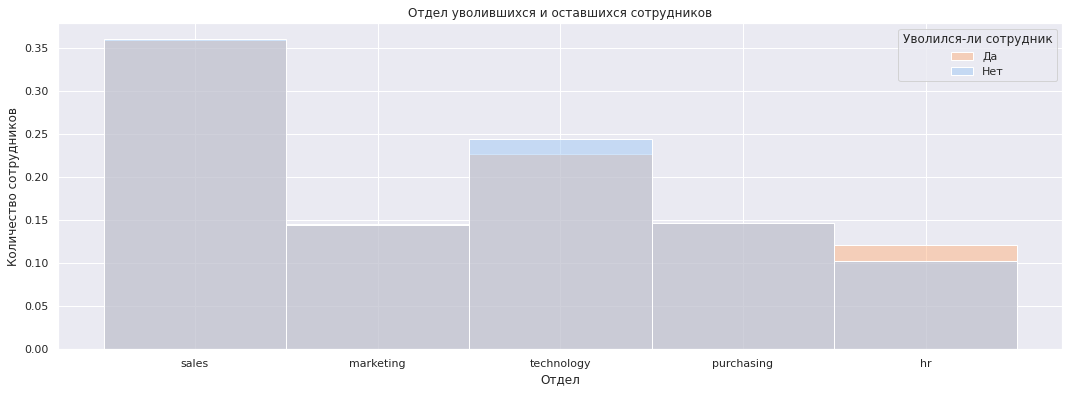

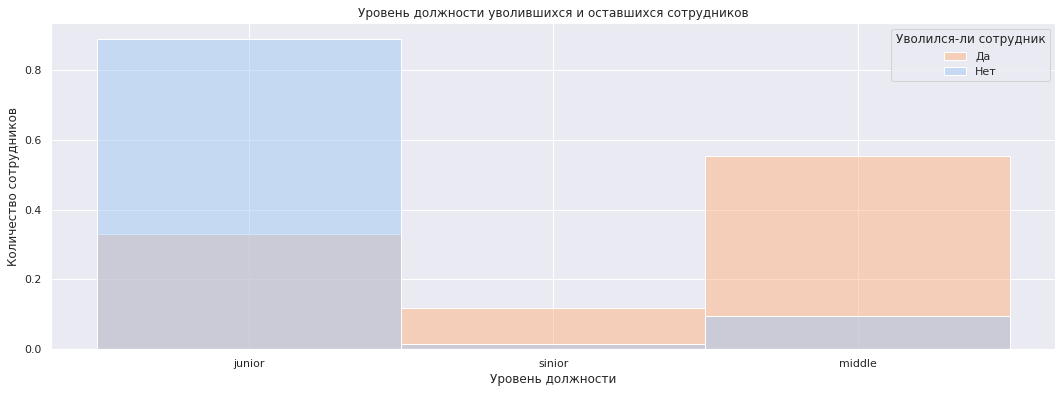

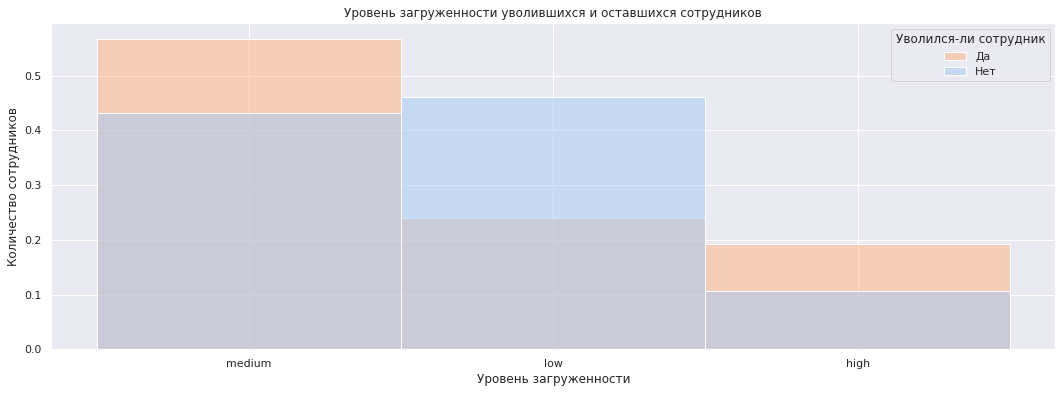

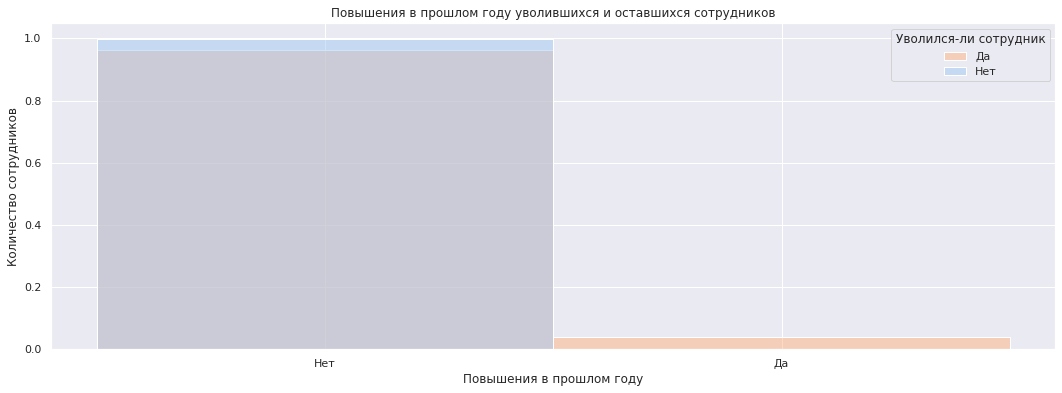

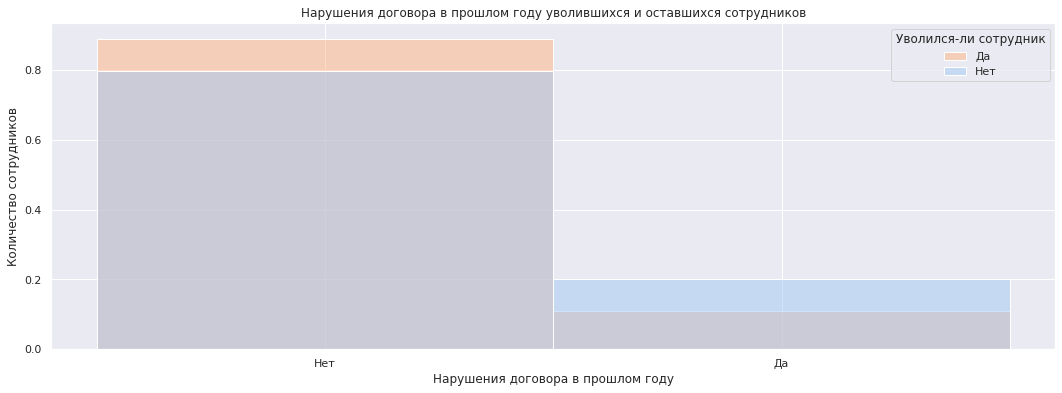

In [57]:
# Выводим гистограммы для пяти столбцов.
category_names, category_labels = (
    ['dept',
     'level',
     'workload',
     'last_year_promo',
     'last_year_violations'],
    ['Отдел',
     'Уровень должности',
     'Уровень загруженности',
     'Повышения в прошлом году',
     'Нарушения договора в прошлом году']
)

for name, label in zip(category_names, category_labels):
#Параметры для гистрограммы c учетом quit
    plt.figure(figsize=(18, 6))
    sns.histplot(
        data=df_train_quit.replace({'yes' : 'Да', 'no' : 'Нет'}).value_counts(normalize=True), 
        x=name,
        hue="quit",
        stat='density', 
        common_norm=False
    )    
    plt.xlabel(label)
    plt.ylabel('Количество сотрудников')
    plt.title(f'{label} уволившихся и оставшихся сотрудников')
    plt.legend(
    ['Да', 'Нет'],
    loc='upper right', 
    title='Уволился-ли сотрудник'
    )
    plt.show() 

Уволившиеся сотрудники преимущественно работали в отделах продаж и ИТ. Они занимали, в основном, начальные позиции. Их рабочая нагрузка была, в основном, низкой и средней. В прошлом году практически никто не получил повышения, а около большая часть нарушили условия своего трудового договора.

В то же время продолжающие работать сотрудники также преимущественно заняты в отделах продаж и ИТ. Они занимают, в основном, средние позиции (больше половины). Их рабочая нагрузка является, в основном, средней (порядка половины). В прошлом году около очень малая часть из них получила повышение, а небольнвя часть нарушила условия своего трудового договора.

По результатам сравнения характеристик уволившихся и продолжающих работать сотрудников, мы можем видеть, что уволившиеся занимали начальные должности в отделах продаж и ИТ, их зарплата была ниже, чем у коллег, они практически не получали повышений, их оценка качества работы была ниже, чем у продолжающих работать, они имели меньшую рабочую нагрузку, чем коллеги, работали в компании относительно небольшое время и, наконец, в процентном соотношении чаще нарушали трудовой договор в прошлом году.

#### Уровень удовлетворенности сотрудников работой в компании может влиять на их решение об увольнении. Это так?

Для проверки утверждения, что уровень удовлетворенности работой в компании влияет на решение сотрудника об увольнении, рассмотрим тестовые данные, которые имеют значения обоих целевых переменных, так как их структура практически полностью совпадает с обучающими данными.

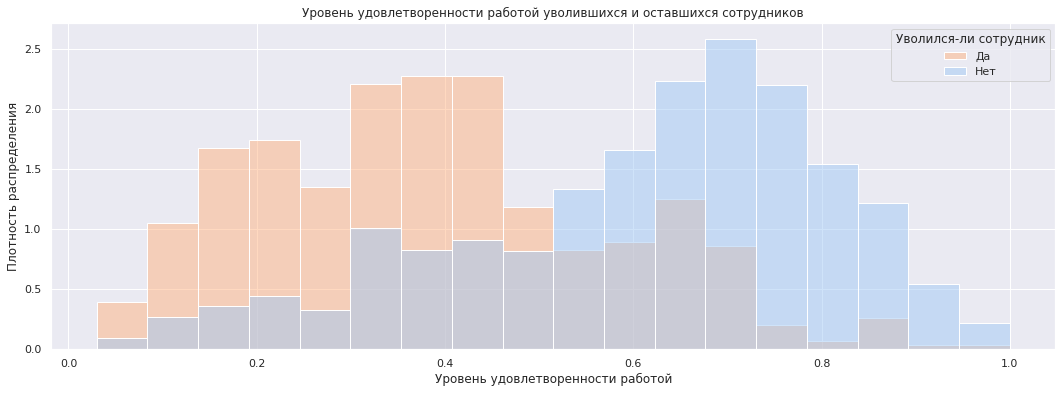

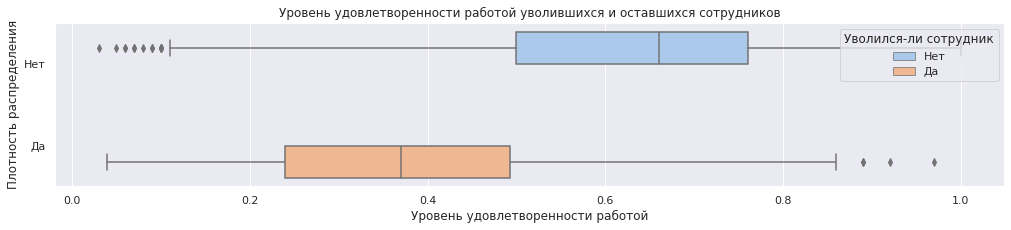

In [58]:
#Вывод гистрограммы для job_satisfaction_rate.
plt.figure(figsize=(18, 6))
sns.histplot(
    data= df_test.merge(
        df_test_satisfaction.merge(
            df_test_quit,
            on = 'id'
        ),
        on = 'id'
    ).replace({'yes' : 'Да', 'no' : 'Нет'}),
        x='job_satisfaction_rate',
    hue="quit",
    stat='density', 
    common_norm=False
)    
plt.xlabel('Уровень удовлетворенности работой')
plt.ylabel('Плотность распределения')
plt.title('Уровень удовлетворенности работой уволившихся '
    'и оставшихся сотрудников')
plt.legend(
['Да', 'Нет'],
loc='upper right', 
title='Уволился-ли сотрудник'
)
plt.show() 

#Вывод "ящика с усами" для job_satisfaction_rate.  
plt.figure(figsize=(17, 3))
sns.boxplot(
    data= df_test.merge(
        df_test_satisfaction.merge(
            df_test_quit,
            on = 'id'
        ),
        on = 'id'
    ).replace({'yes' : 'Да', 'no' : 'Нет'}),
    x='job_satisfaction_rate',
    y='quit',
    hue="quit"
)
plt.xlabel('Уровень удовлетворенности работой')
plt.ylabel('Плотность распределения')
plt.title('Уровень удовлетворенности работой уволившихся '
    'и оставшихся сотрудников')
plt.legend(
loc='upper right', 
title='Уволился-ли сотрудник'
)
plt.show() 
    

Данные однозначно показывают нам, что уровень удовлетворенности работой уволившихся сотрудников был ниже, чем у их оставшихся коллег.

## Добавление нового входного признака

Поскольку на предыдущем шаге мы получили подтверждение того, что `job_satisfaction_rate` и `quit` связаны, мы можем добавить в наши данные прогнозы лучшей модели из первой задачи.

Поскольку в первой задаче мы разделили наш пайплайн на несколько этапов в разных ячейках, для получения прогнозов модели нам нужно привести `df_train_quit` к виду, в котором `df_train_satisfaction` поступал в модель раньше. Пропусков в наших датафреймах нет, поэтому мы пропустим шаги, связанные с `SimpleImputer` и сразу перейдем к подготовке новых данных для первой модели.

Датафрейм `df_test` уже был подготовлен для первой модели, поэтому нам нужно просто сохранить ранее полученные трансформированные данные и полученные прогнозы в новый датафрейм, не забывая объединить `df_test` и `df_test_quit` по `id`. Перед разделением на предикторные и целевую переменные обучающих данных давайте удостоверимся, что после удаления столбца `id` в них не появляются дубликаты.

In [59]:
# Выводим информацию о количестве дубликатов
# в датафрейме df_train_quit, если убрать
# столбец id, удаляем дубликаты и проверяем,
# что в данных не осталось дубликатов.
print(
    f'Количество дубликатов в датафрейме df_train_quit '
    f'до манипуляций: '
    f"{df_train_quit.drop('id', axis = 1).duplicated().sum()}"
)

df_train_quit = df_train_quit.drop('id', axis = 1).drop_duplicates()

print(
    f'Количество дубликатов в датафрейме df_train_quit '
    f'после манипуляций: '
    f'{df_train_quit.duplicated().sum()}'
)

# Задаем тренировочные данные для второй модели.
X_train_model_2 = df_train_quit.drop(['quit'], axis = 1)
y_train_model_2 = df_train_quit['quit']

# Сохраняем кодированные и масштабированные данные,
# чтобы получить предсказания первой модели.
X_train_model_2 = pd.DataFrame(
    data_preprocessor.transform(X_train_model_2),
    columns = new_columns
)

# Получаем предсказания job_satisfaction_rate.
y_model_forecast_2 = model_exercise_1.predict(X_train_model_2)

# Сохраняем данные в датафрейм для второй модели.
X_train_model_2 = pd.concat(
    [X_train_model_2,
     pd.Series(
         y_model_forecast_2,
         index = X_train_model_2.index
     )],
    axis = 1
).rename(columns = {0 : 'job_satisfaction_rate'})

# Объединяем датафрейм с целевым и тестовыми признаками.
df_target_quit = df_test.merge(df_test_quit, on = 'id')

# Задаем тестовые данные.
X_test_model_2 = pd.concat(
    [X_test_model_1,
     pd.Series(
         y_model_forecast_1,
         index = X_test_model_1.index
     )],
    axis = 1
).rename(columns = {0 : 'job_satisfaction_rate'})

y_test_model_2 = df_target_quit['quit']

Количество дубликатов в датафрейме df_train_quit до манипуляций: 1413
Количество дубликатов в датафрейме df_train_quit после манипуляций: 0


Мы добавили в наши данные предсказания job_satisfaction_rate, используя пайплайн и модель из первого задания.

## Подготовка данных

Мы установили на этапе исследовательского анализа данных, что количество уволившихся и оставшихся сотрудников сильно различается.   

Поскольку для оценки качества второй модели мы собираемся использовать метрику `ROC-AUC` которая не чувствительна к дисбалансу классов, у нас нет необходимости его устранять.

Для кодирования целевой переменной `quit` применим `LabelEncoder` К сожалению, этот кодировщик не может использоваться в пайплайне по причине особенностей реализации методов `fit`, `fit_transform` и `transform` Мы создадим свой собственный класс, где переопределим эти методы, чтобы включить `LabelEncoder` в пайплайн.

In [60]:
# Создаем собственный класс с функциями.
class LabelEncoding():

    def transform(self, X, **fit_params):
        enc = LabelEncoder()
        enc_fitted = enc.fit(X)
        enc_final = enc_fitted.transform(X)

        return pd.Series(enc_final, index = X.index, name = X.name)

    def fit_transform(self, X, y = None, **fit_params):
        self.fit(X, **fit_params)
        return self.transform(X)

    def fit(self, X, y = None, **fit_params):
        return self

# Создаем пайплайн для кодирования.
le = Pipeline([('le', LabelEncoding())])

# Кодируем таргет в тренировочной и тестовой выборках.
y_train_model_2_LE = le.fit_transform(y_train_model_2)
y_test_model_2_LE = le.transform(y_test_model_2)

Для оценки качества второй модели мы используем метрику `ROC-AUC`, которая не зависит от дисбаланса классов, поэтому нет необходимости его исправлять. Для кодирования целевой переменной мы использовали `LabelEncoder`. Таким образом, наши данные полностью готовы для модели.

## Обучение моделей и выбор лучшей из них

Нам осталось создать пайплайн для обучения моделей. Согласно условиям задания, нам нужно использовать три модели для классификации, по крайней мере для двух из которых задать гиперпараметры. Мы используем четыре модели: `DecisionTreeClassifier`, `KNeighborsClassifier`, `LogisticRegression`, `RandomForestClassifier`. Все они поддерживают настройку гиперпараметров. Для оценки качества моделей будем использовать встроенную меру `ROC-AUC`.

In [61]:
#Создаем пайплайн с моделью.
class_models_pipe = Pipeline([ 
    ('models', DecisionTreeClassifier(random_state = RANDOM_STATE)) 
])

#Словари для моделей.
param_grid = [
    #Словарь для модели DecisionTreeClassifier().
    {
        'models' : [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'models__max_depth' : [3, 5, 15, 25],
        'models__max_features' : [3, 5, 10],
        'models__min_samples_split' : [3, 5, 10]
    },
    #Словарь для модели KNeighborsClassifier().
    {
        'models' : [KNeighborsClassifier()],
        'models__metric': ['euclidean', 'cityblock'],
        'models__n_neighbors' : [3, 5, 7, 9, 11, 13, 15],
        'models__weights' : ['distance', 'uniform']
    },
    #Словарь для модели LogisticRegression().
    {
        'models': [LogisticRegression(random_state = RANDOM_STATE)],
        'models__C': [0.1, 1.0, 10.0], 
        'models__penalty': ['l2'],
        'models__solver' : ['lbfgs', 'liblinear']
    },
    #Словарь для модели RandomForestClassifier().
    {
        'models' : [RandomForestClassifier(random_state = RANDOM_STATE)],
        'models__max_depth' : [19],
        'models__max_features' : [3],
        'models__min_samples_leaf' : [7],
        'models__n_estimators' : [200]
    }
]

#Задаем настройки поиска оптимальных параметров.
model_search_2 = GridSearchCV(
    class_models_pipe,
    param_grid,
    scoring = 'roc_auc',
    n_jobs = -1
) 

#Производим поиск оптимальных параметров модели.
model_search_2.fit(X_train_model_2, y_train_model_2_LE)

#Выводим лучшую модель.
print(
    f'Лучшая модель и ее параметры:\n\n {model_search_2.best_estimator_} \n\n')

#Выводим значение ROC-AUC для тренировочных данных.
print(
    f'Метрика ROC-AUC лучшей модели на тренировочной выборке: '
    f'{model_search_2.best_score_:,.2f}'
    .replace('.', ','),
    end = '.\n'
)

Лучшая модель и ее параметры:

 Pipeline(steps=[('models',
                 RandomForestClassifier(max_depth=19, max_features=3,
                                        min_samples_leaf=7, n_estimators=200,
                                        random_state=42))]) 


Метрика ROC-AUC лучшей модели на тренировочной выборке: 0,91.


Сохраним полученную модель, передадим ей тестовые данные для вычисления предсказаний целевого признака и расчитаем значение `ROC-AUC` для этих данных.

In [62]:
# Сохраняем модель с параметрами из пайплайна.
model_exercise_2 = model_search_2.best_estimator_

# Получаем предсказания для тестовой выборки.
y_model_forecast_2 = model_exercise_2.predict_proba(X_test_model_2)[:,1]

# Выводим значение ROC-AUC для тестовой выборки.
print(
    f'Метрика ROC-AUC лучшей модели на тестовой выборке: '
    f'{roc_auc_score(y_test_model_2_LE, y_model_forecast_2):,.2f}'
    .replace('.', ','),
    end = '.'
)

Метрика ROC-AUC лучшей модели на тестовой выборке: 0,93.

По условию задания, критерий успеха - значение `ROC-AUC` больше или равное 0,91. Итак, мы нашли хорошую модель для прогнозирования увольнения сотрудника из компании.

Мы провели поиск по сетке параметров для четырех моделей (логистическая регрессия, дерево решений, метод k-ближайших соседей и метод случайного леса). В результате работы пайплайна мы получили лучшую модель RandomForestClassifier со следующими гиперпараметрами:`max_depth = 19`, `max_features = 3`, `min_samples_leaf = 7`, `n_estimators=200`. Значение метрики `ROC-AUC` для тестовых данных равно 0.93.

## Промежуточные выводы

Мы выполнили загрузку и первичную оценку данных ранее, поэтому не стали повторять этот шаг снова.

Предварительная обработка данных в `df_test` была выполнена ранее при решении первой задачи. В `df_train_quit` и `df_test_quit` не было пропущенных значений, все значения соответствовали заявленным типам данных и не было дубликатов.

Были изучены все столбцы данных в двух датафреймах (`df_test` был проанализирован нами ранее в этом проекте). Мы обнаружили, что средний сотрудник в обучающей и тестовой выборках идентичен, поэтому результаты, полученные после обучения на обучающей выборке, могут быть использованы для работы с тестовой выборкой. Средний сотрудник работает в компании на должности младшего специалиста в отделе продаж или ИТ, его нагрузка средняя. В прошлом году у него не было повышений или нарушений трудовых договоров. Этот сотрудник работает в компании 3.701 года, его зарплата составляет 33 805.8 рублей в месяц, а оценка его работы начальником - 3.475. Мы также описали, какие инструменты планируем использовать для кодирования и масштабирования признаков.

По результатам сравнения характеристик уволившихся и продолжающих работать сотрудников, мы обнаружили, что уволившиеся занимали стартовые позиции в продажах и ИТ, получали зарплату ниже своих коллег, почти не получали повышений, оценка качества их работы начальником была ниже, чем у оставшихся, имели меньшую рабочую нагрузку, чем их продолжающие работать коллеги, работали в компании относительно короткое время и чаще нарушали трудовой договор в процентах в прошлом году.

Даные четко показали нам, что удовлетворенность работой уволившихся сотрудников была ниже), чем у продолжающих работать коллег. В соответствии с результатами предыдущего шага, мы добавили предсказание `job_satisfaction_rate` в наш дата-фрейм, используя пайплайн и модель из первой задачи.

Поскольку для оценки качества второй модели используется метрика `ROC-AUC`, нечувствительная к дисбалансу классов, то у нас не было необходимости устранять его на этапе подготовки данных. Для кодирования целевого признака мы использовали `LabelEncoder`.

Мы провели поиск по сетке гиперпараметров для четырех моделей: логистической регрессии, дерева решений, k-ближайщих соседей и случайного леса. В результате работы пайплайна мы получили наилучшие результаты для модели `RandomForestClassifier` с гиперпараметрами `ax_depth=19` `ax_features=3` `min_samples_leaf=7`, `n_estimators=200`. Значение ROC-AUC метрики для тестовых данных составляет 0.93

# Общий вывод

Были поставлены две задачи:
1. Создать модель, которая бы предсказывала уровень удовлетворенности сотрудника и показывала значение метрики `SMAPE` на тестовых данных менее или равное `15`.
2. Создать модель, которая бы предсказывала уволнение сотрудника из компании и показывала значение метрики `ROC-AUC` на тестовых данных более или равное `0,91`.

Промежуточные результаты работы над каждой из задач описаны в соответствующих разделах проекта. Подытожим.

По итогам работы над первой задачей мы получили модель дерева решений с такими параметрами: `max_depth = 25`, `max_features = 10`, `min_samples_split = 10`. Метрика `SMAPE` для тестовых данных показала значение 13.65, это хороший результат.

Gо результатам работы над второй задачей мы создали модель классификации методом случайного леса с такими параметрами:  `max_depth = 19`, `max_features = 3`, `min_samples_leaf = 7`, `n_estimators=200`. `ROC-AUC` метрика для тестовых данных получила значение 0.93, это также хороший результат.

Несмотря на то, что исходные данные для анализа подготовлены хорошо, полученные предсказания являются довольно приблизительными. Возможно, это связано с тем, что показатель `SMAPE` имеет ошибку более 13,5%. Из-за этого вторая модель может показывать результаты хуже, чем могла бы при более точных предсказаниях `job_satisfaction_rate` Как мы можем видеть, работа на стартовых позициях в компании, особенно в маркетинге и ИТ, часто приводит к тому, что сотрудники уходят из компании уже через год.

Во-первых, сотрудники были недовольны отсутствием возможности для повышения (ни один из уволившихся не получил повышение за год).   
Во-вторых, зарплаты уволившихся были значительно ниже среднего по компании (медианная зарплата уволившихся ниже нижней границы первого квартиля среди оставшихся).  
В-третьих, уволившиеся работали с меньшей нагрузкой, а в-четвертых, их оценки от руководителей были ниже, чем у коллег.  
Получается, что компания теряет молодых специалистов, которые приходят в компанию за опытом и работой. Но они не получают достойной компенсации за свое время в денежном выражении, не получают повышений, не имеют достаточного объема работы. В итоге они также получают низкие оценки от своего руководства.

Компании стоит пересмотреть свою стратегию найма новых сотрудников на стартовые позиции. Если текущая тенденция сохранится, поток кандидатов может сильно сократиться. Компания столкнется с кадровым голодом, и условия найма будут определяться не компанией, а кандидатами на должности.